# Model Testing - RAVDESS
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

This notebook implements the testing of the final model on the RAVDESS dataset.
- Test-time augmentation and top-k ($k = 3$) methods are also used.
- GPU is not used. 

The sections are as follows -
- [Load Files](#load_files)
- [Imports](#imports)
- [Data Preparation](#data_preparation)
- [Testing Parameters](#testing_parameters)
- [Model Parameters](#model_parameters)
- [Visualization](#visualization)
- [Session I](#session_one)
- [Session II](#session_two)
- [Session III](#session_three)
- [Session IV](#session_four)
- [Save Files](#save)

<a id='load_files'></a>
## Load Files
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

- Loading the RAVDESS Spectrograms, RAVDESS Meta, IEMOCAP Meta, network module, visualization module, and helper module into the session storage (for use in Colab).
- Additionally installing `torchmetrics`.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/RAVDESS Spectrograms.zip' 'RAVDESS Spectrograms.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/RAVDESS Meta.zip' 'RAVDESS Meta.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/IEMOCAP Meta.zip' 'IEMOCAP Meta.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/network.zip' 'network.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/visualization.zip' 'visualization.zip'
!cp '/content/gdrive/My Drive/Speech Emotion Recognition Project/helper.zip' 'helper.zip'

!unzip 'RAVDESS Spectrograms.zip'
!unzip 'RAVDESS Meta.zip'
!unzip 'IEMOCAP Meta.zip'
!unzip 'network.zip'
!unzip 'visualization.zip'
!unzip 'helper.zip'

!pip install torchmetrics

Streaming output truncated to the last 5000 lines.
  inflating: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-02-02-22/03-01-06-02-02-02-22_aug2.png  
   creating: RAVDESS Spectrograms/Test/Fearful/03-01-06-01-01-01-12/
  inflating: RAVDESS Spectrograms/Test/Fearful/03-01-06-01-01-01-12/03-01-06-01-01-01-12_aug4.png  
  inflating: RAVDESS Spectrograms/Test/Fearful/03-01-06-01-01-01-12/03-01-06-01-01-01-12_aug5.png  
  inflating: RAVDESS Spectrograms/Test/Fearful/03-01-06-01-01-01-12/03-01-06-01-01-01-12_aug1.png  
  inflating: RAVDESS Spectrograms/Test/Fearful/03-01-06-01-01-01-12/03-01-06-01-01-01-12_aug2.png  
  inflating: RAVDESS Spectrograms/Test/Fearful/03-01-06-01-01-01-12/03-01-06-01-01-01-12_aug6.png  
  inflating: RAVDESS Spectrograms/Test/Fearful/03-01-06-01-01-01-12/03-01-06-01-01-01-12_aug3.png  
   creating: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-02-02-04/
  inflating: RAVDESS Spectrograms/Test/Fearful/03-01-06-02-02-02-04/03-01-06-02-02-02-04_aug3.png  
  inflating

<a id='imports'></a>
## Imports
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Importing the required functions from the network module.
> `model` - Code for model class.<br>
> `batch` - Code for batch-related operations.
<br>
> `train` - Code for training the network.

In [2]:
import sys
sys.path.append('./network')

from network.model import ComplexNetwork
from network.batch import get_augmentations
from network.train import test_ravdess_network, get_single_ravdess, get_ravdess_classwise

#### Step 2:
- Importing the required functions from the visualization module.
    > `explanation` - Code for conducting explanatory visualizations.<br>
    > `exploration` - Code for conducting exploratory visualizations.

In [3]:
sys.path.append('./visualization')

from visualization.explanation import plot_confusion_matrix, plot_per_class, display_test_data
from visualization.explanation import plot_classwise_pred, plot_ravdess_prediction, plot_img_pred
from visualization.exploration import show_test_samples, plot_split

#### Step 3:
Importing the required functions from the helper module.
> `network` - Code for general-purpose functions of network module.<br>
> `visualization` - Code for general-purpose functions of visualization module.


In [4]:
from helper.network import load_data, get_emotion_num, get_classification_metric, get_confusion_matrix
from helper.visualization import get_dataframe

#### Step 4:
- Importing required modules from `pytorch`.
- Increasing quality of plots.

In [5]:
import torch

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

<a id='data_preparation'></a>
## Data Preparation
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Loading `label_data`, `split_data`, `class_data`, `stats`, and model architecture.

In [6]:
root = './RAVDESS Spectrograms'
rav_meta_root = './RAVDESS Meta'
iem_meta_root = './IEMOCAP Meta'
roots = (root, rav_meta_root, iem_meta_root)
rav_name = 'ravdess'
iem_name = 'iemocap'

label_data = load_data(rav_meta_root, 'Label')
split_data = load_data(rav_meta_root, 'Split')
rav_class_data = load_data(rav_meta_root, 'Class')

iem_class_data = load_data(iem_meta_root, 'Class')
stats = load_data(iem_meta_root, 'Statistics')
ARCH = load_data(iem_meta_root, 'Selected')

In [7]:
ARCH = {
    'input': (129, 129),
    'convolutional': [
        {'input': None, 'output': 32, 'kernel': 7, 'stride': 2, 'padding': 3},
        {'input': 32, 'output': 64, 'kernel': 5, 'stride': 1, 'padding': 2},
    ],
    'pooling': [
        {'kernel': 3, 'stride': 2},
        {'kernel': 2, 'stride': 2}
    ],
    'hidden': [
        {'input': 16384, 'output': 2048}
    ],
    'output': None,
    'pool position': [1, 2]
}

#### Step 2:
- Obtaining the number of outputs for each task.
- Defining the type of each task.

In [8]:
iem_num_outputs = [get_emotion_num(iem_name, iem_class_data), 2, 1, 1, 1]
rav_num_outputs = [get_emotion_num(rav_name, rav_class_data), 2, 2]
num_outputs = [get_emotion_num(iem_name, iem_class_data), 2, 2]

iem_tasks = ('Emotions', 'Genders', 'Valence', 'Activation', 'Dominance')
iem_task_type = ('classification', 'classification', 'regression', 'regression', 'regression')
print('----------\nIEMOCAP\n----------')
for i, output in enumerate(iem_num_outputs):
    print(f'{iem_tasks[i]}: {output}')

rav_tasks = ('Emotions', 'Genders', 'Intensity')
rav_task_type = ('classification', 'classification', 'classification')

print('----------\nRAVDESS\n----------')
for i, output in enumerate(rav_num_outputs):
    print(f'{rav_tasks[i]}: {output}')

----------
IEMOCAP
----------
Emotions: 8
Genders: 2
Valence: 1
Activation: 1
Dominance: 1
----------
RAVDESS
----------
Emotions: 6
Genders: 2
Intensity: 2


<a id='testing_parameters'></a>
## Testing Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview:
- Defining testing parameters. Metrics selected are -
> - **Accuracy** - Computes ratio of number of samples correctly classified to total number of samples.<br>
> - **F1 Score** - Harmonic mean of precision and recall. Here, ${\beta}$ = 1 indicating equal weightage to precision and recall.

- Additionally, `average_type` is the method of averaging classification metric results. The chosen methods are -
> - **macro** - This calculates the metric for each class separately, and average the metrics across classes (with equal weights for each class).<br>
> - **weighted** - This calculates the metric for each class separately, and averages the metrics across classes, weighting each class by its support (`tp` + `fn`). This is good for an imbalanced dataset.<br>
> - **none** - This calculates the metric for each class separately, and returns the metric for every class.<br>

- Only highest prediction is considered.
> `top_k` - number of highest probability predictions considered to find the correct label.
- In this case, weighted accuracy is the same as micro accuracy and micro f1 score.
> Classification metrics are defined in each session.

#### Step 1:
Defining confusion matrix (for classification) -
> This is a table with that reports the number of true positives, false negatives, false positives, and true negatives.
> This allows more detailed analysis than accuracy for imbalanced dataset.

In [9]:
confusion_matrix = get_confusion_matrix(num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                        num_intensity = rav_num_outputs[2], name = rav_name)

#### Step 2:
Packing the testing parameters.
> **Min-Max Scaler** - Each value is transformed using $\frac{\text{x} \text{ - } \text{min}}{\text{max} \text{ - } \text{min}}$.

In [10]:
torch_params = {'conf matrix': confusion_matrix}
other_params = {'scaling type': stats['scaling type'], 'task type': rav_task_type, 'num augs': None}

scaling_type = stats['scaling type']
print(f"Scaling Type - '{scaling_type}'")

Scaling Type - 'min-max'


<a id='model_parameters'></a>
## Model Parameters
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Obtaining the input normalization transform. Each channel is transformed using $\frac{\text{channel input} \text{ - } \text{channel mean}}{\text{channel std}}$.
> `color_map` - color map for images.<br>
> `channel_mean` - mean for each channel.<br>
> `channel_std` - standard deviation for each channel.

In [11]:
channel_mean, channel_std, color_map = stats['channel mean'], stats['channel std'], stats['color map']

transforms = [channel_mean, channel_std, color_map]
print(f'Channel Mean - {transforms[0]} | Channel Std - {transforms[1]} | Color Map - {transforms[2]}')

Channel Mean - [0.2746834032590987] | Channel Std - [0.17490942513599714] | Color Map - L


#### Step 2:
Assigning the model's input and output size.

In [12]:
all_transforms = [ARCH['input']]
all_transforms.extend(transforms)
ARCH['output'] = iem_num_outputs
ARCH['convolutional'][0]['input'] = 1 if color_map == 'L' else 3

#### Step 3:
- Defining the parameters -
> `layer_params` - parameters for the layers of the network.<br>
> `multi_params` - parameters for the multitask network.

| Layer Parameters | Multitask Parameters |
| :-: | :-: |
| Activation - ReLU | Loss Type - weighted param |
| Pooling - MaxPool | Loss Weights - None |
| Dropout - 0.8 | Task Layers - None | 
| Batch Norm - False |
| Attention - 0.0001 |
| Weight Init - False |

In [13]:
multitask_params = {'loss type': 'weighted param', 'loss weights': None, 'task layers': None}
layer_params = {
    'activation': 'relu', 'pooling': 'max', 'dropout': 0.8, 'batch norm': False, 
    'attention': 0.0001, 'weight init': False
               }

#### Step 4:
Loading the trained model.

In [14]:
best_model = torch.load(f'{iem_meta_root}/Best.pt', map_location = torch.device('cpu'))
model = ComplexNetwork(ARCH, layer_params, multitask_params, iem_task_type)
model.load_state_dict(best_model['model'])

model_params = (model, all_transforms)

<a id='visualization'></a>
## Visualization
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Step 1:
Plotting label distribution in the dataset.

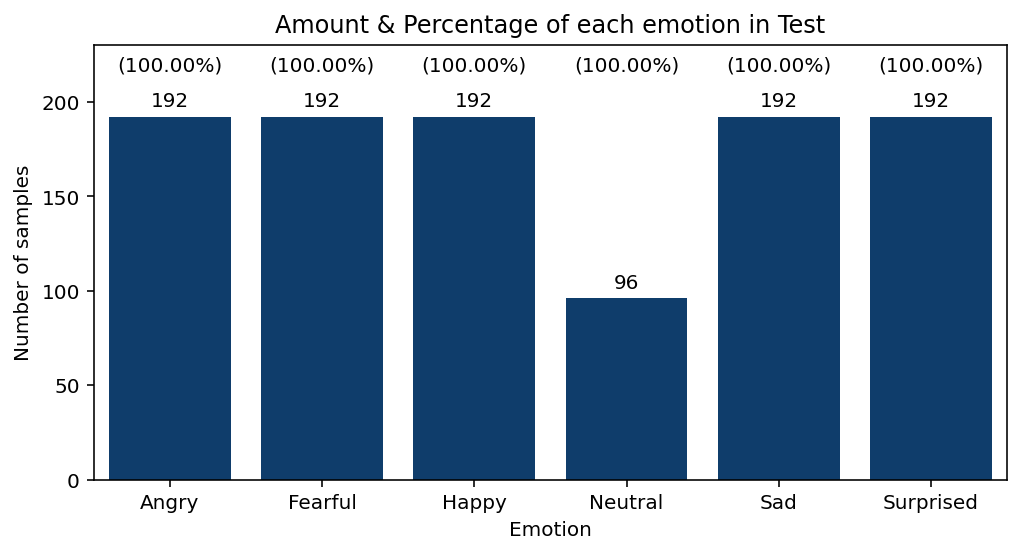

In [15]:
label_df = get_dataframe(label_data, rav_name, 'label')
plot_split(split_data, label_df, label_data, list(rav_class_data.keys())[:-4])

#### Step 2:
Calculating the size of the data.

In [16]:
num_test = len(split_data['test'])
print(f'Number of test samples = {num_test}')

Number of test samples = 1056


#### Step 3:
Visualizing the batch samples with and without augmentations.

In [17]:
img_size = ARCH['input']

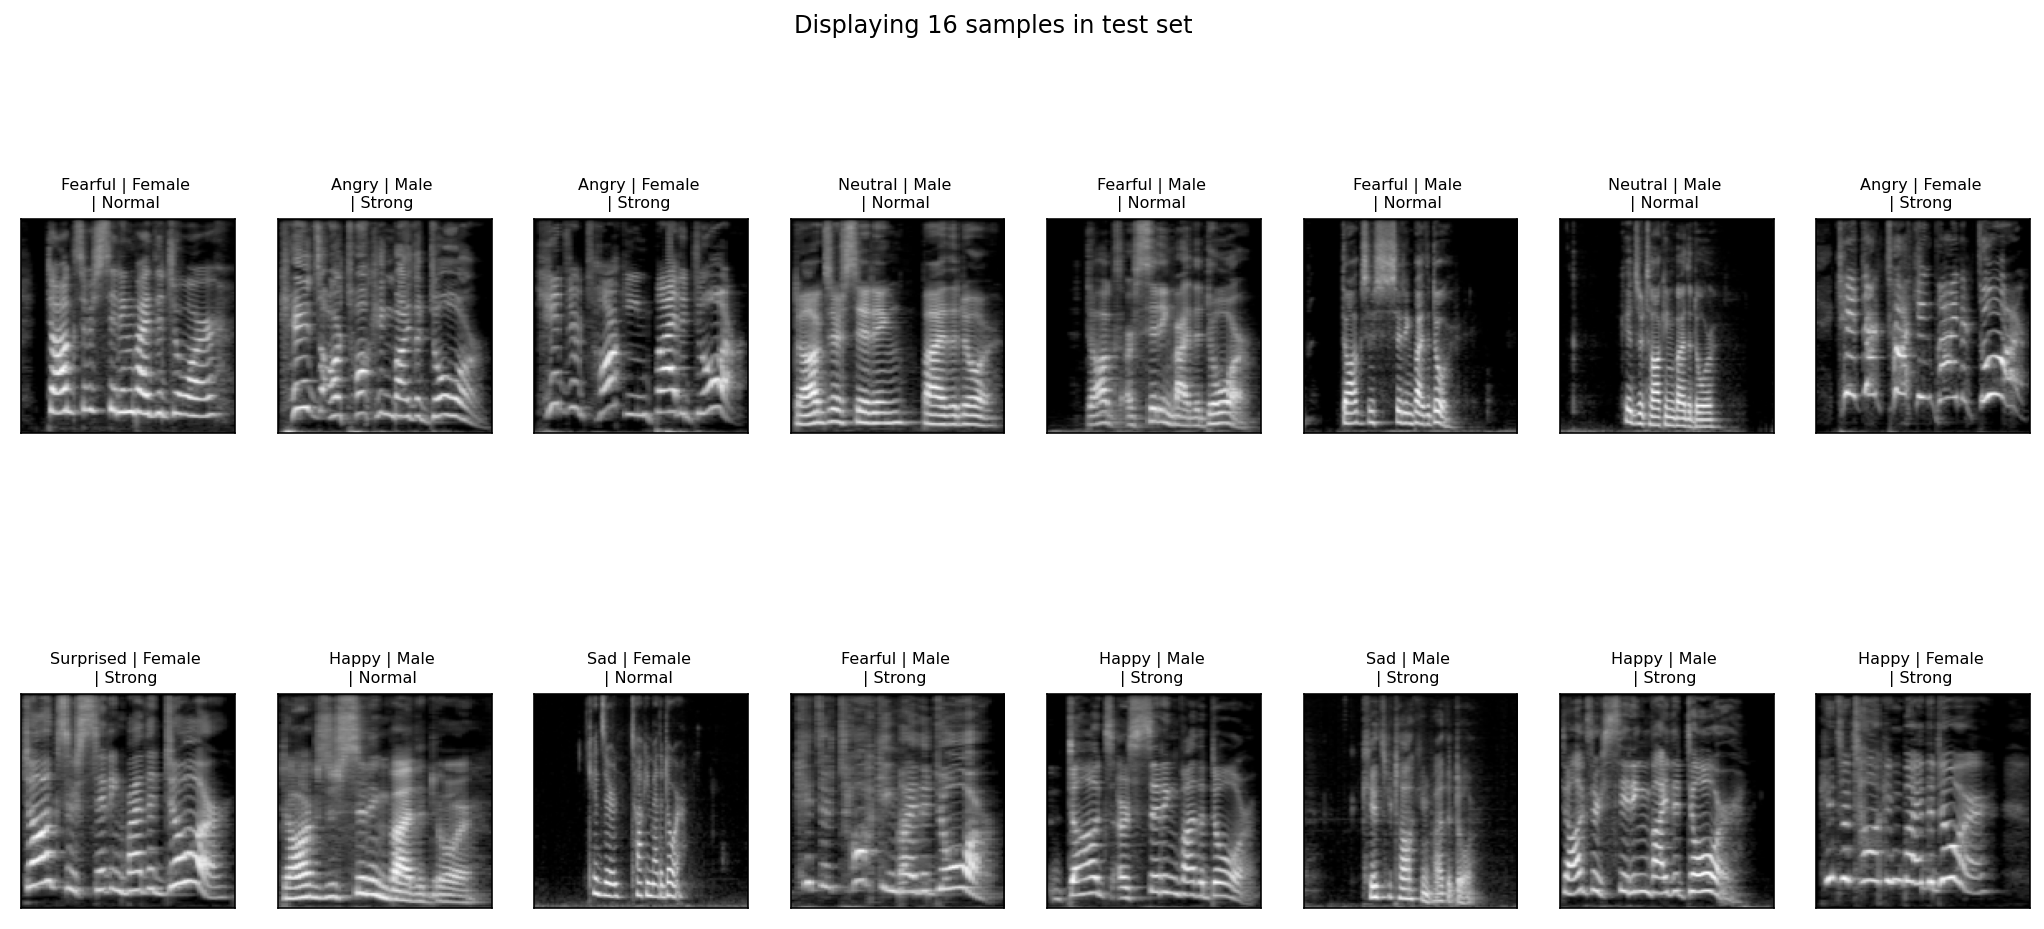

In [18]:
plot_params = (rav_name, color_map, img_size, False)
show_test_samples(root, split_data['test'], label_data, plot_params, num_samples = 16)

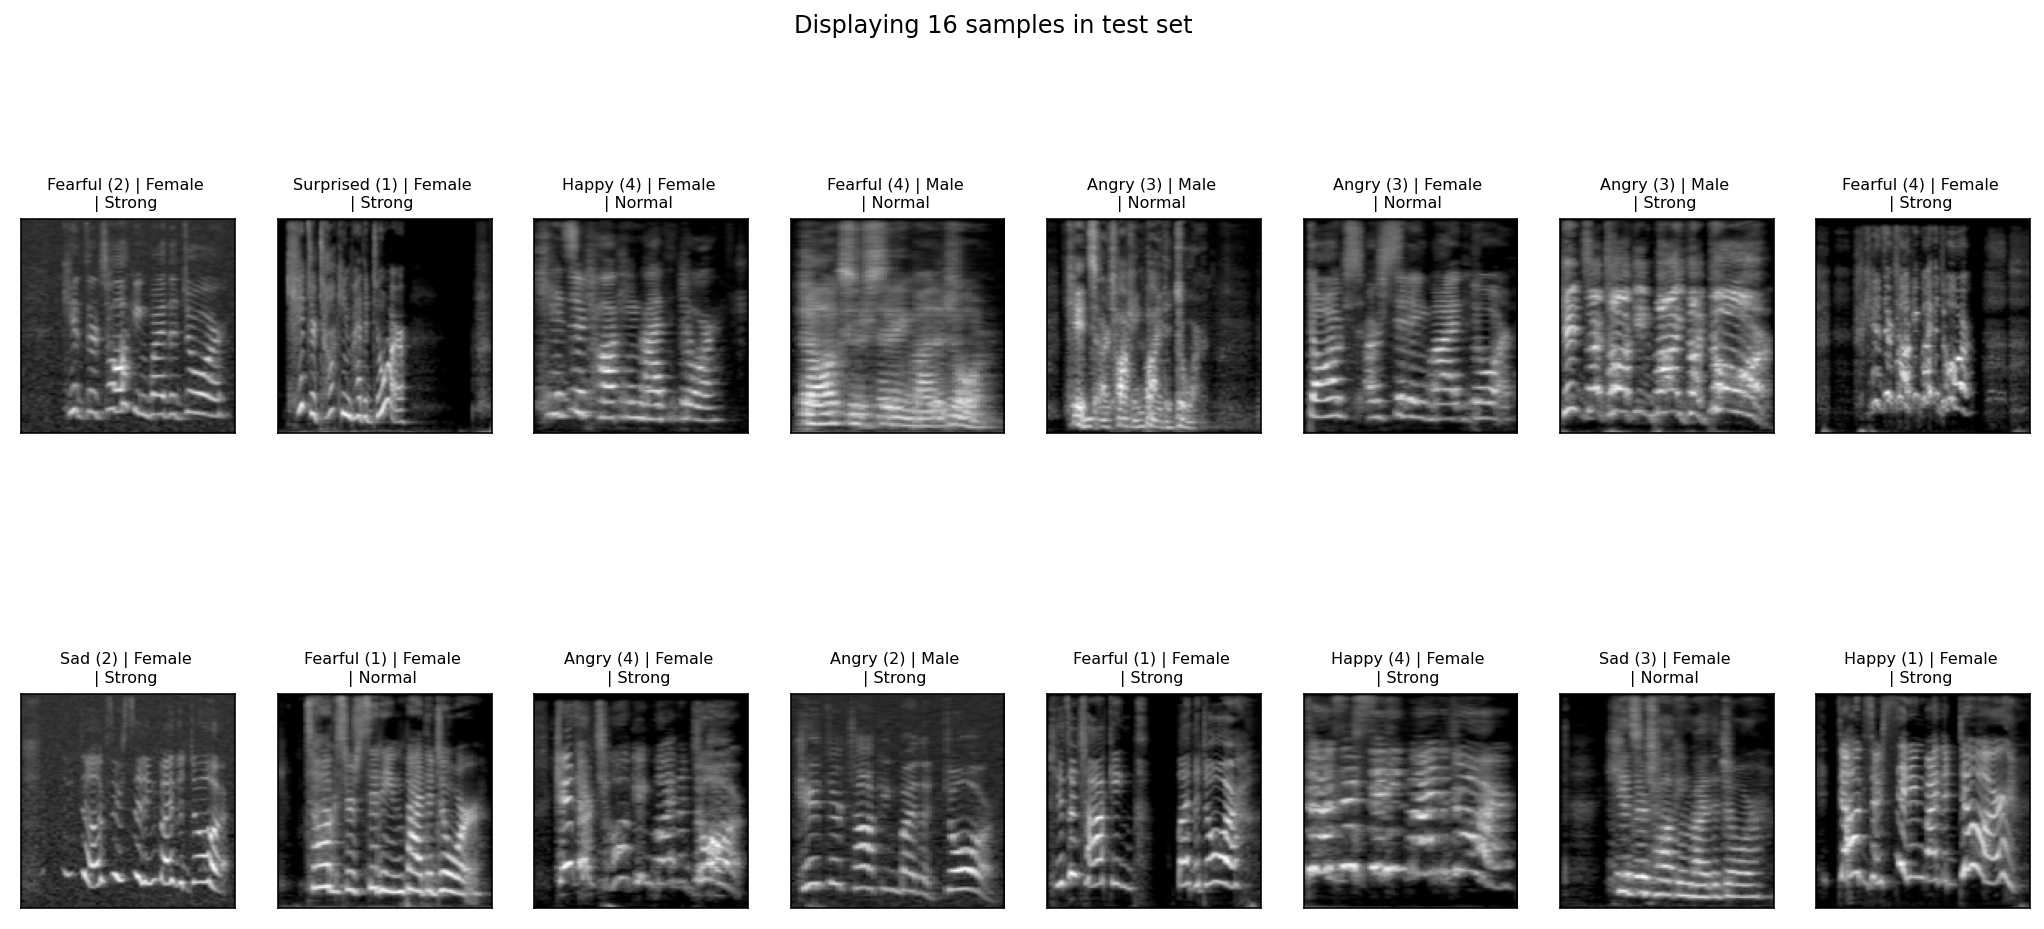

In [19]:
test_data = get_augmentations(split_data['test'], num_augs = [1,2,3,4])

plot_params = (rav_name, color_map, img_size, True)
show_test_samples(root, test_data, label_data, plot_params, num_samples = 16)

<a id='session_one'></a>
## Session I
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- `test_network` performs testing of the model -
> - Each sample is loaded and transformations are applied.
> - Before normalization, each image is resized and converted to a tensor.
> - Numerical predictions and labels are scaled back to original values before being fed to their corresponding metric.

- `num_augs` - Number of augmentations of a sample used. In this session, only original samples are used.
- `top_k` - set to **1**. 
- `aug_type` - augmentation to plot.

| Number | Augmentation Type |
| :-: | :-: |
| 1 | Original |

In [20]:
other_params['num augs'] = [1]
aug_type = 1
top_k = 1

metrics_weight = get_classification_metric('weighted', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)
metrics_macro = get_classification_metric('macro', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)
metrics_none = get_classification_metric('none', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)

plot_params = (rav_task_type, aug_type, all_transforms)
torch_params['metrics weight'] = metrics_weight
torch_params['metrics macro'] = metrics_macro
torch_params['metrics none'] = metrics_none

#### Step 1:
Testing the model.

In [21]:
test_ravdess_network(roots, model_params, torch_params, other_params, name = '1')

IntProgress(value=0, description='Making predictions...', layout=Layout(width='500px'), max=2, style=ProgressS…

#### Step 2:
- Loading the model data.
- Displaying the metrics.

In [22]:
test_results = torch.load(f'{rav_meta_root}/Test-1.pt')

In [23]:
columns = ('Task', 'Weighted Accuracy', 'Weighted F1 Score')
display_test_data(test_results['weighted metric'], rav_tasks, columns, 'classification')

columns = ('Task', 'Macro Accuracy', 'Macro F1 Score')
display_test_data(test_results['macro metric'], rav_tasks, columns, 'classification')

Task Weighted Accuracy Weighted F1 Score
1   Emotions             21.40            0.1186
2    Genders             86.65            0.8659
3  Intensity             65.72            0.6579

Task Macro Accuracy Macro F1 Score
1   Emotions          21.88         0.1319
2    Genders          86.65         0.8659
3  Intensity          65.82         0.6564

#### Step 3:
Plotting the predictions of a random image.

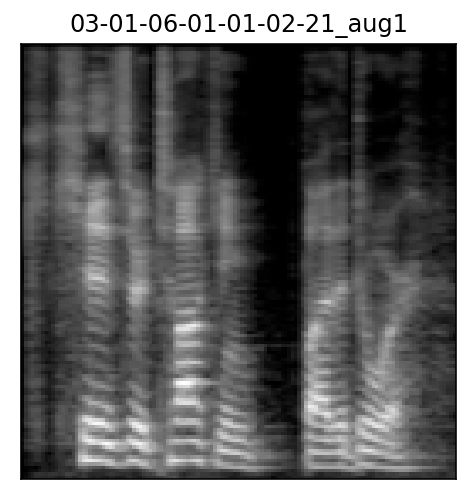

In [24]:
preds, pred_labels, file_name, img = get_single_ravdess(roots, model, 'test', plot_params)
plot_img_pred(file_name, img, color_map, aug_type)

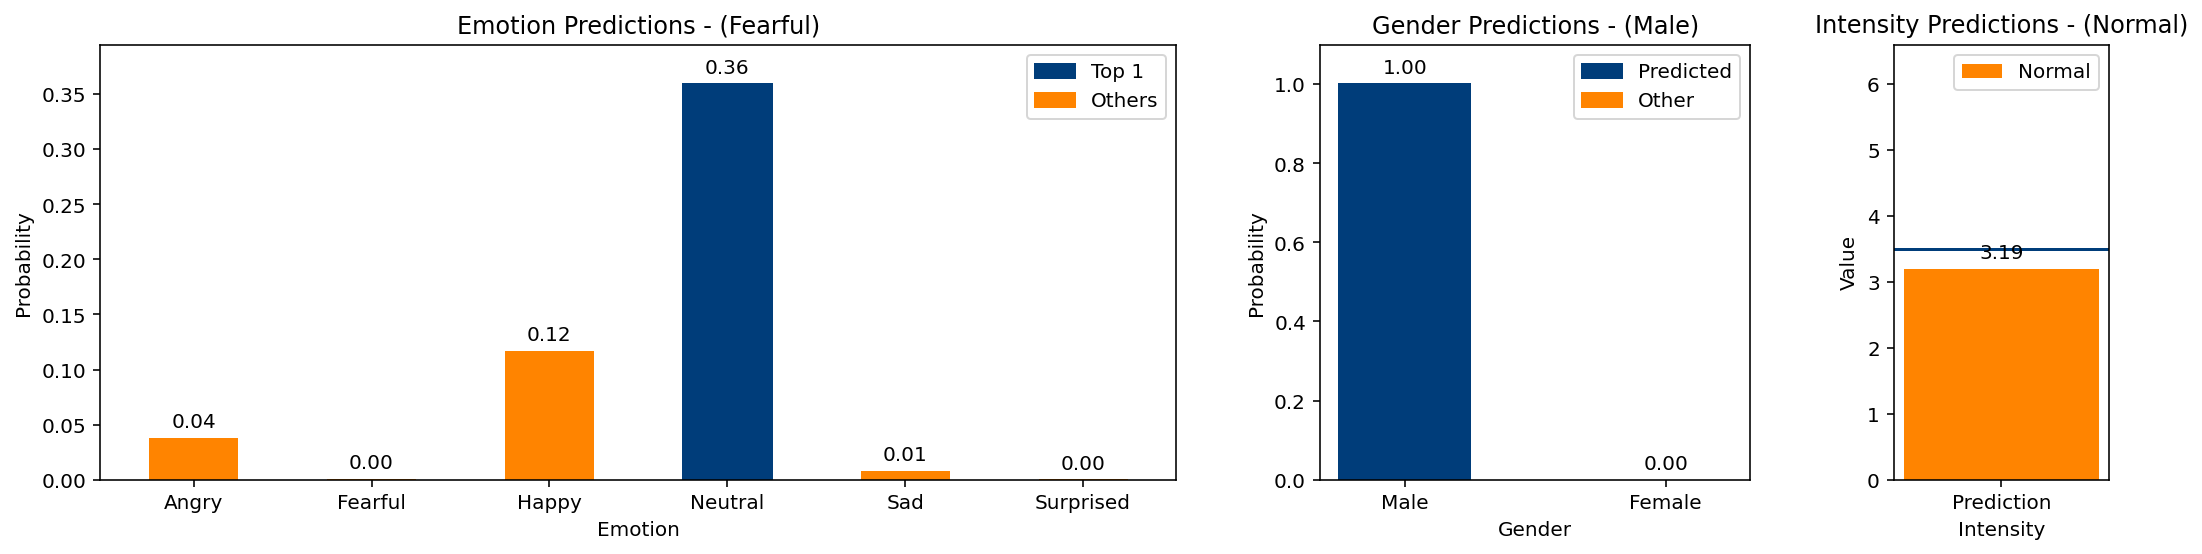

In [25]:
plot_ravdess_prediction(roots, preds, pred_labels, top_k = top_k)

#### Step 4:
Prediction performance on test set images.
> - Each plot displays the predictions made for several spectrograms of a class. 
> - The prediction is the probablity that the spectrogram belongs to that class. 

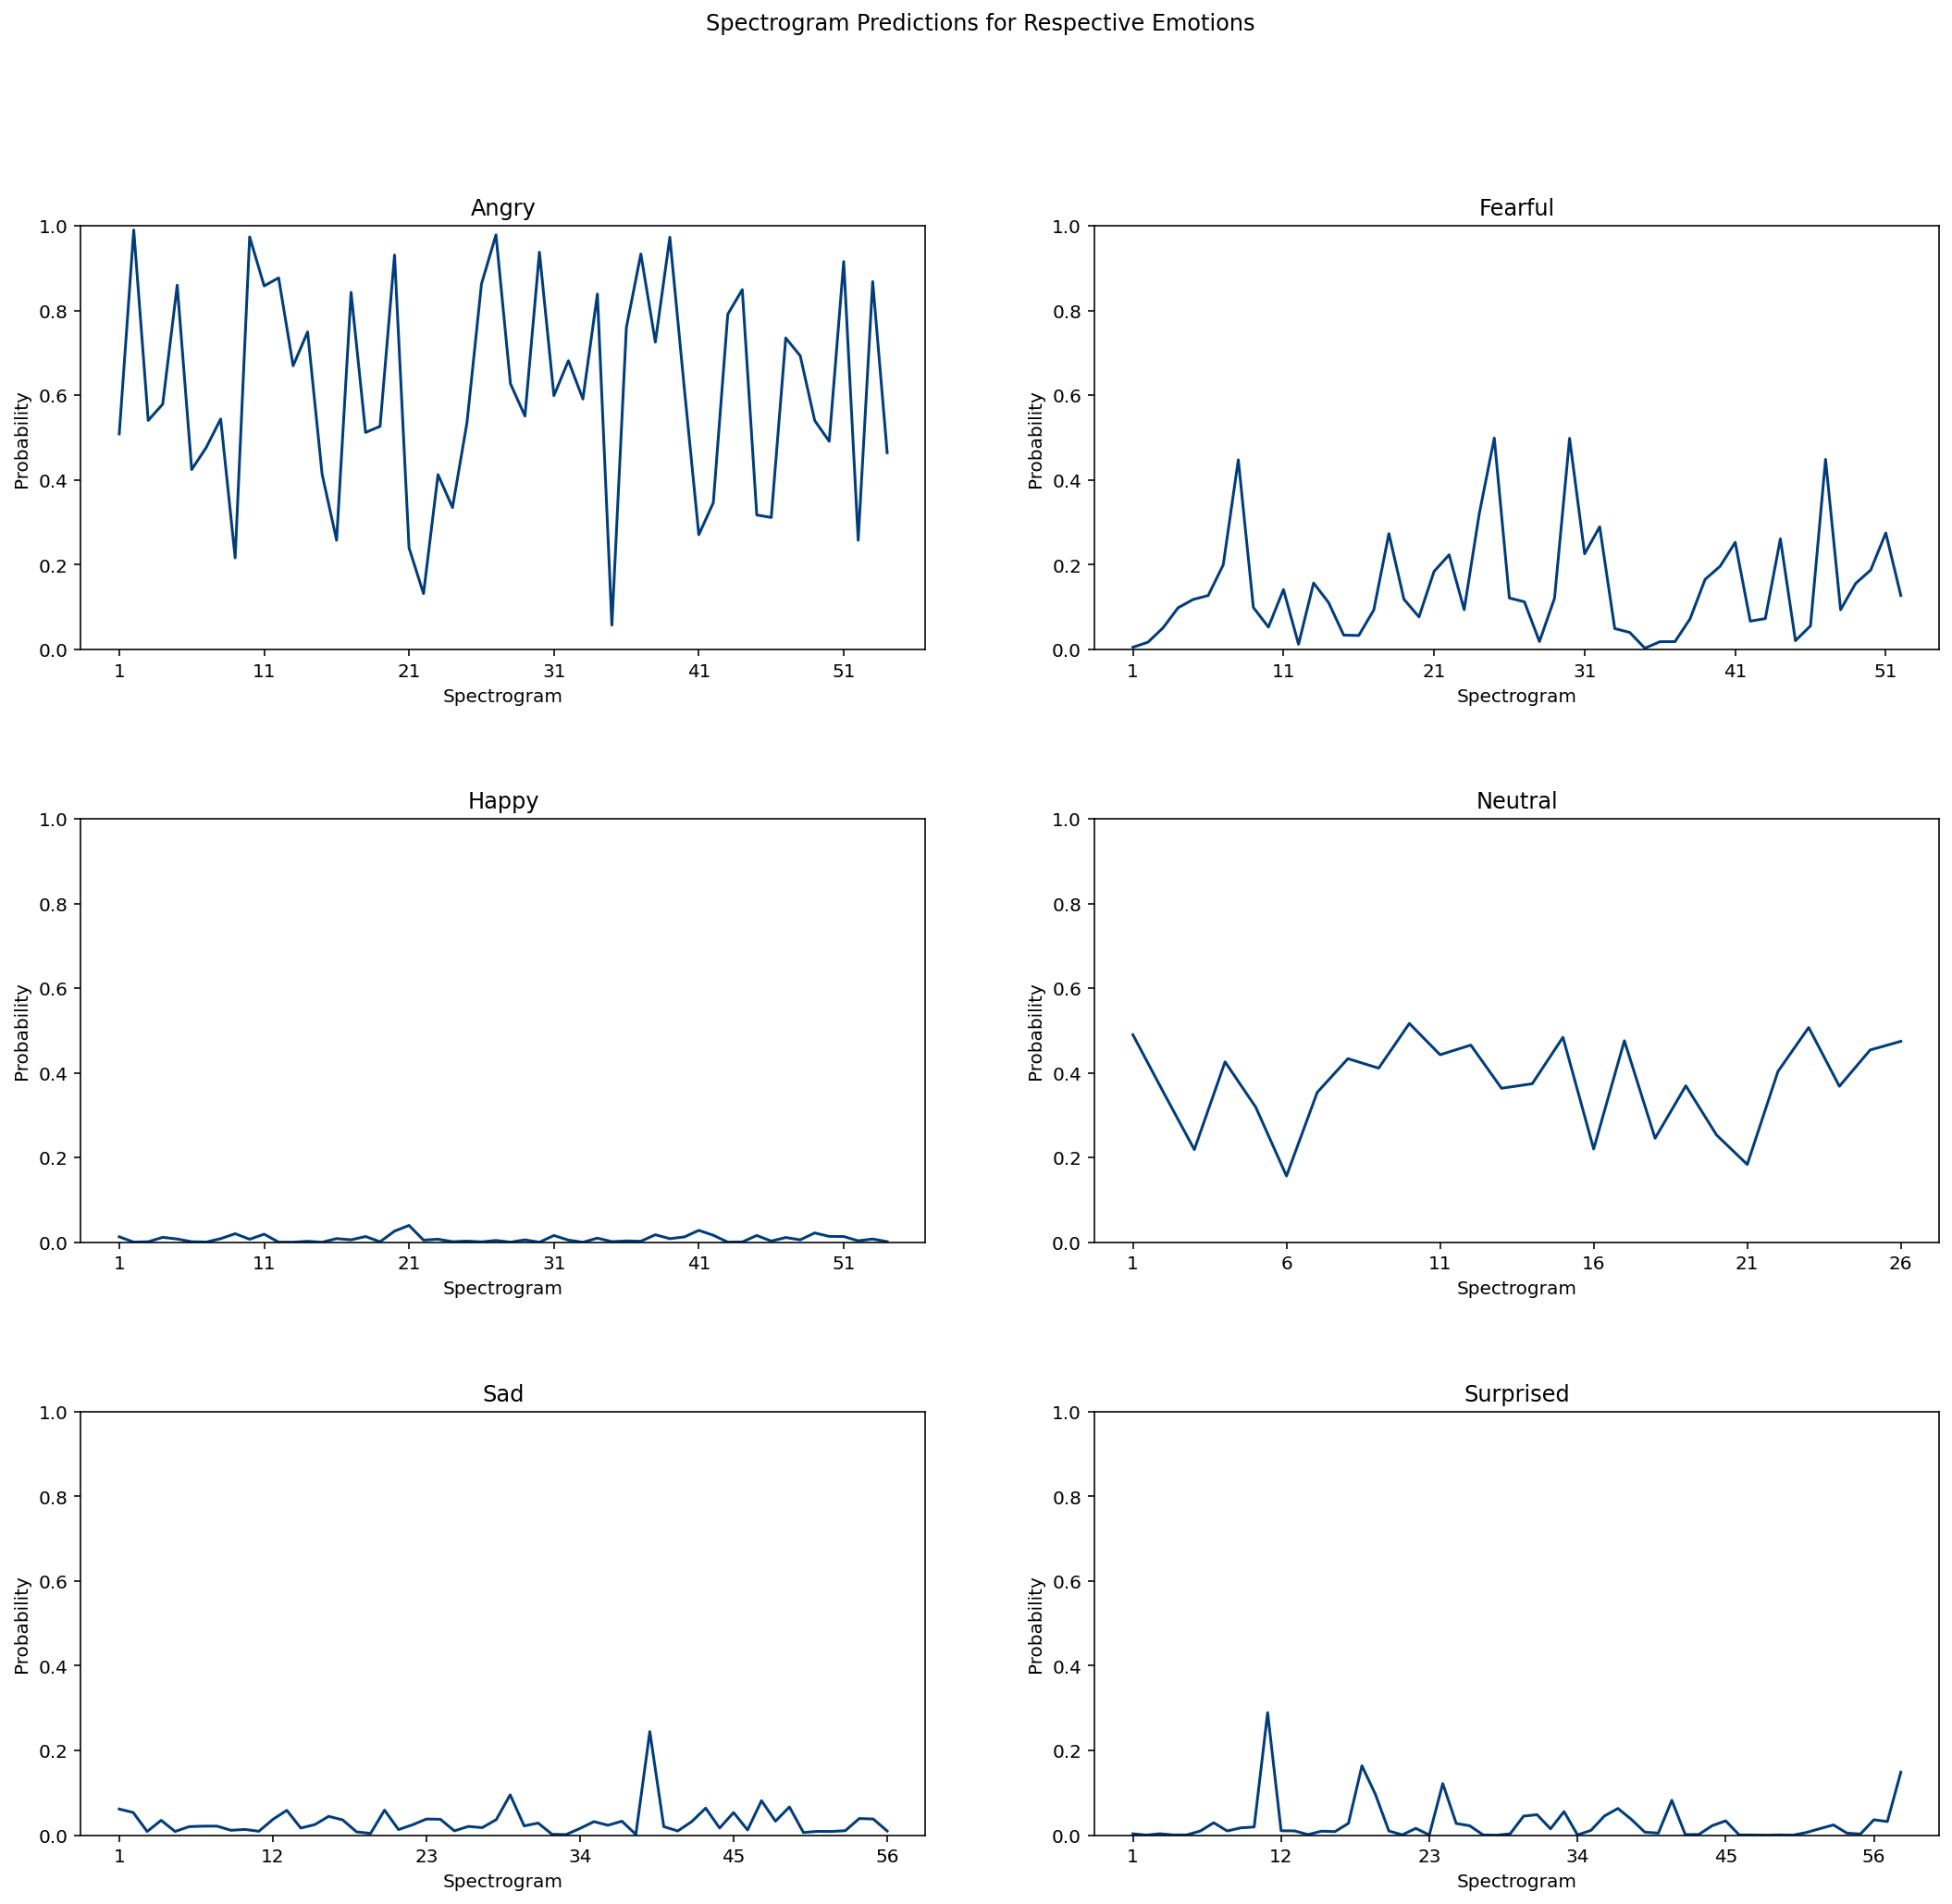

In [26]:
emotion, gender = get_ravdess_classwise(roots, model, plot_params, num_samples = 300)
plot_classwise_pred(emotion, list(rav_class_data.keys())[:-4], 'Emotions', (18, 16))

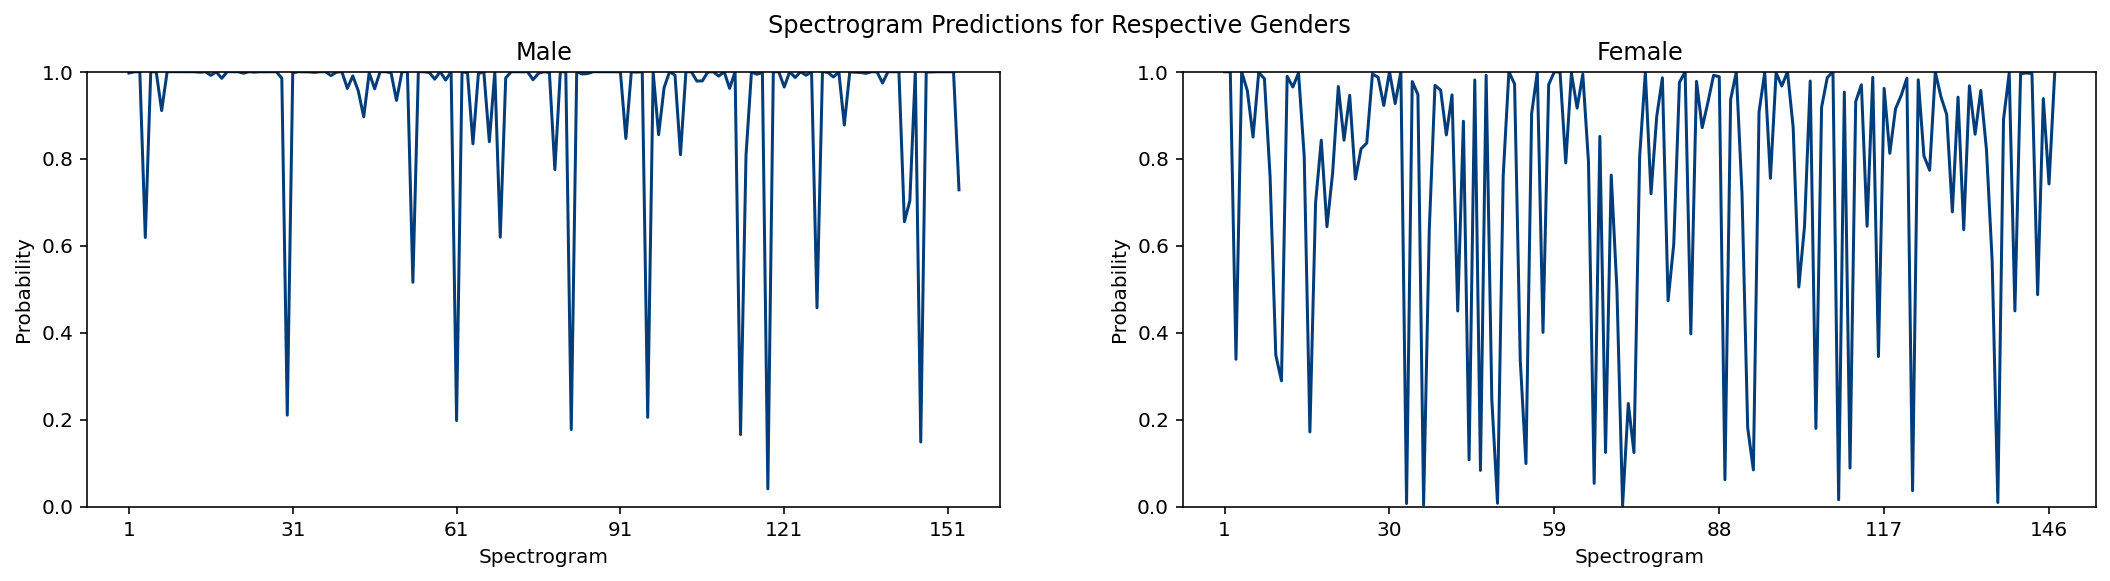

In [27]:
plot_classwise_pred(gender, list(rav_class_data.keys())[-4:-2], 'Genders', (18, 4))

#### Step 5:
Plotting the classification metrics per class.

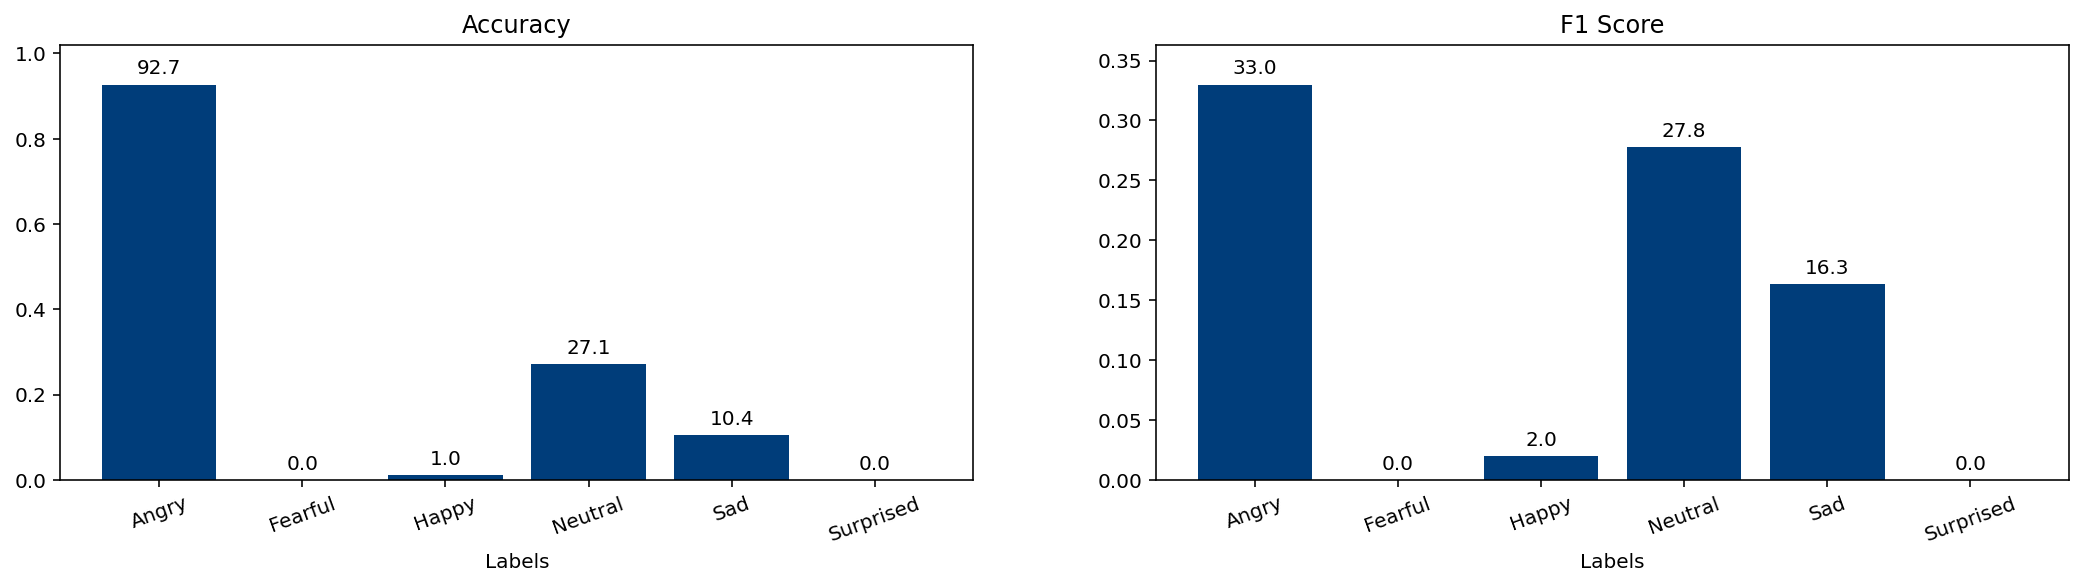

In [28]:
plot_per_class(test_results, tuple(rav_class_data.keys())[:-4], 'Emotion')

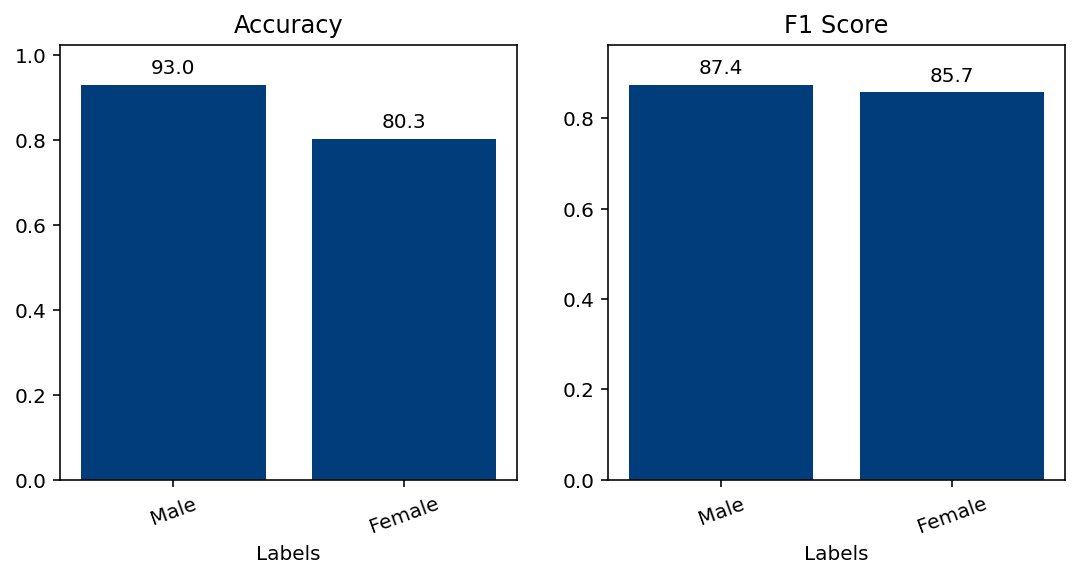

In [29]:
plot_per_class(test_results, tuple(rav_class_data.keys())[-4:-2], 'Gender')

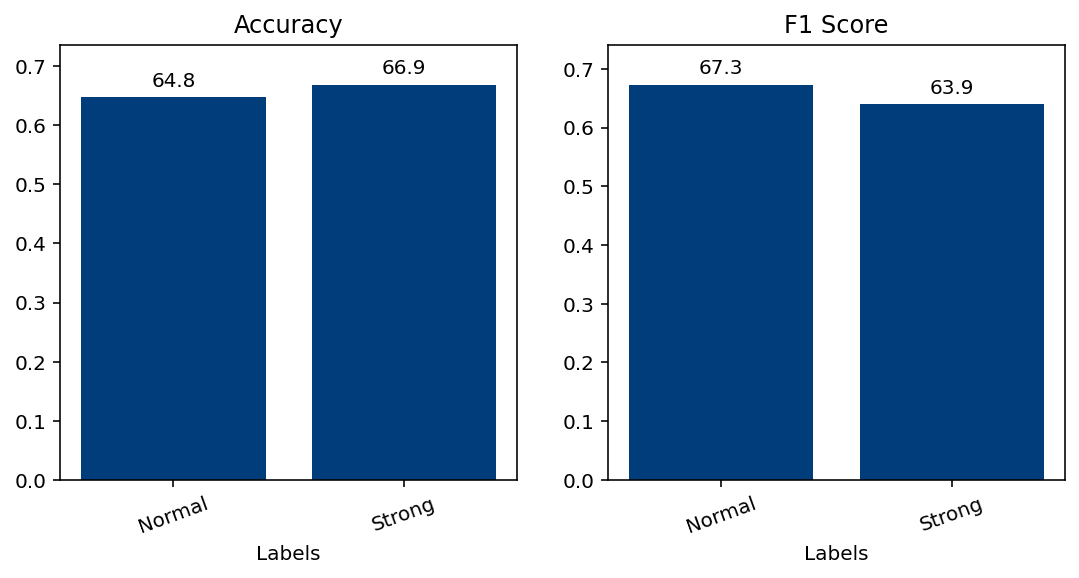

In [30]:
plot_per_class(test_results, tuple(rav_class_data.keys())[-2:], 'Intensity')

#### Step 6:
Plotting the confusion matrix.

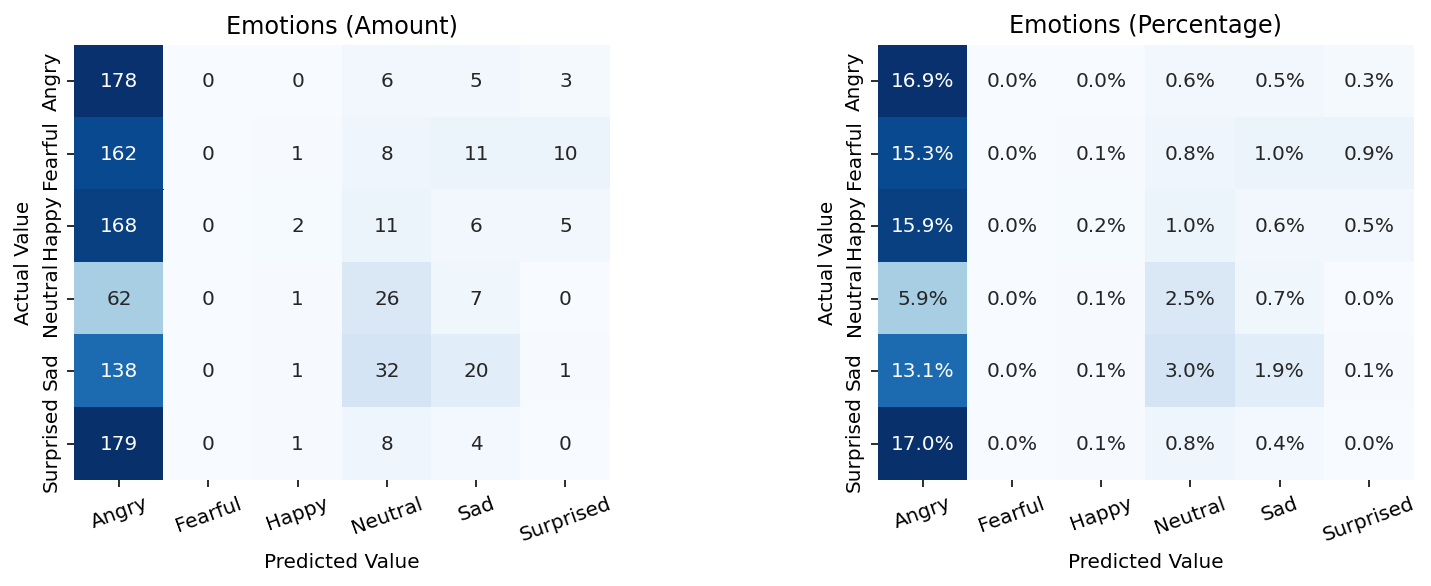

In [31]:
plot_confusion_matrix(test_results['confusion matrix'][0], tuple(rav_class_data.keys())[:-4], 'Emotions', fig_size = (12,4), wspace = 0.5)

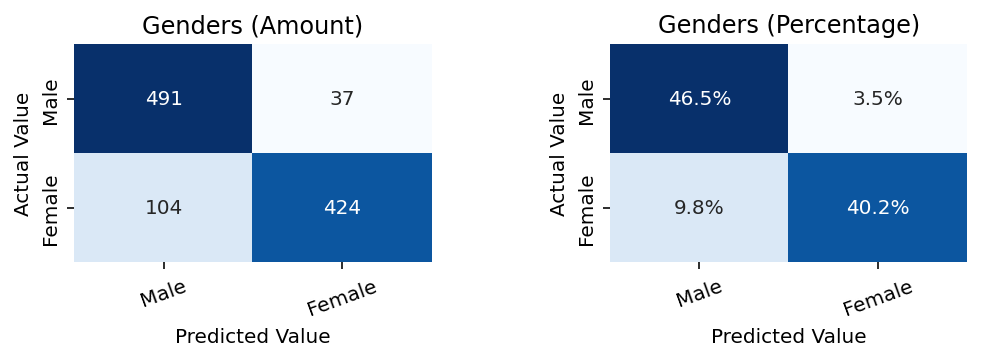

In [32]:
plot_confusion_matrix(test_results['confusion matrix'][1], tuple(rav_class_data.keys())[-4:-2], 'Genders', fig_size = (8,2), wspace = 0.5)

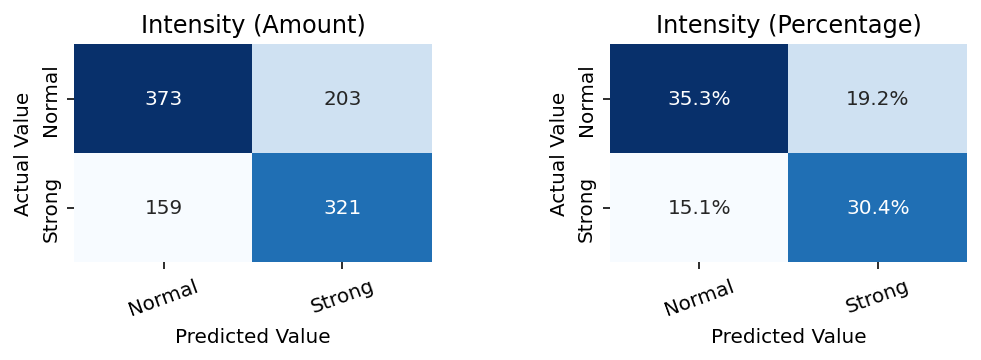

In [33]:
plot_confusion_matrix(test_results['confusion matrix'][2], tuple(rav_class_data.keys())[-2:], 'Intensity', fig_size = (8,2), wspace = 0.5)

<a id='session_two'></a>
## Session II
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
In Test-Time Augmentation, predictions are made for all augmentations of a sample and combined to obtain a single prediction.
> **Classification** - predictions are converted to probabilities which are then averaged.<br>
> **Regression** - predictions are averaged.

- `num_augs` - using 3 augmentations.
- `top_k` - set to **1**. 
- `aug_type` - augmentation to plot.

| Number | Augmentation Type |
| :-: | :-: |
| 1 | Original |
| 2 | Noise |
| 3 | Time Stretch |
| 4 | Pitch Shift |

In [34]:
other_params['num augs'] = [1, 2, 3, 4]
aug_type = 1
top_k = 1

metrics_weight = get_classification_metric('weighted', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)
metrics_macro = get_classification_metric('macro', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)
metrics_none = get_classification_metric('none', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)

plot_params = (rav_task_type, aug_type, all_transforms)
torch_params['metrics weight'] = metrics_weight
torch_params['metrics macro'] = metrics_macro
torch_params['metrics none'] = metrics_none

#### Step 1:
Testing the model.

In [35]:
test_ravdess_network(roots, model_params, torch_params, other_params, name = '2')

IntProgress(value=0, description='Making predictions...', layout=Layout(width='500px'), max=2, style=ProgressS…

#### Step 2:
- Loading the model data.
- Displaying the metrics.

In [36]:
test_results = torch.load(f'{rav_meta_root}/Test-2.pt')

In [37]:
columns = ('Task', 'Weighted Accuracy', 'Weighted F1 Score')
display_test_data(test_results['weighted metric'], rav_tasks, columns, 'classification')

columns = ('Task', 'Macro Accuracy', 'Macro F1 Score')
display_test_data(test_results['macro metric'], rav_tasks, columns, 'classification')

Task Weighted Accuracy Weighted F1 Score
1   Emotions             21.59            0.1205
2    Genders             86.46            0.8641
3  Intensity             66.95            0.6692

Task Macro Accuracy Macro F1 Score
1   Emotions          22.14         0.1339
2    Genders          86.46         0.8641
3  Intensity          66.58         0.6661

#### Step 3:
Plotting the predictions of a random image.

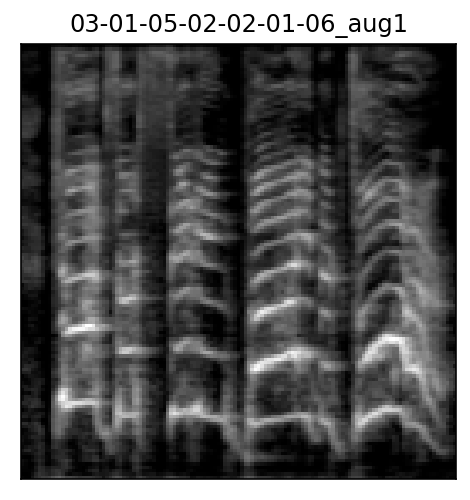

In [38]:
preds, pred_labels, file_name, img = get_single_ravdess(roots, model, 'test', plot_params)
plot_img_pred(file_name, img, color_map, aug_type)

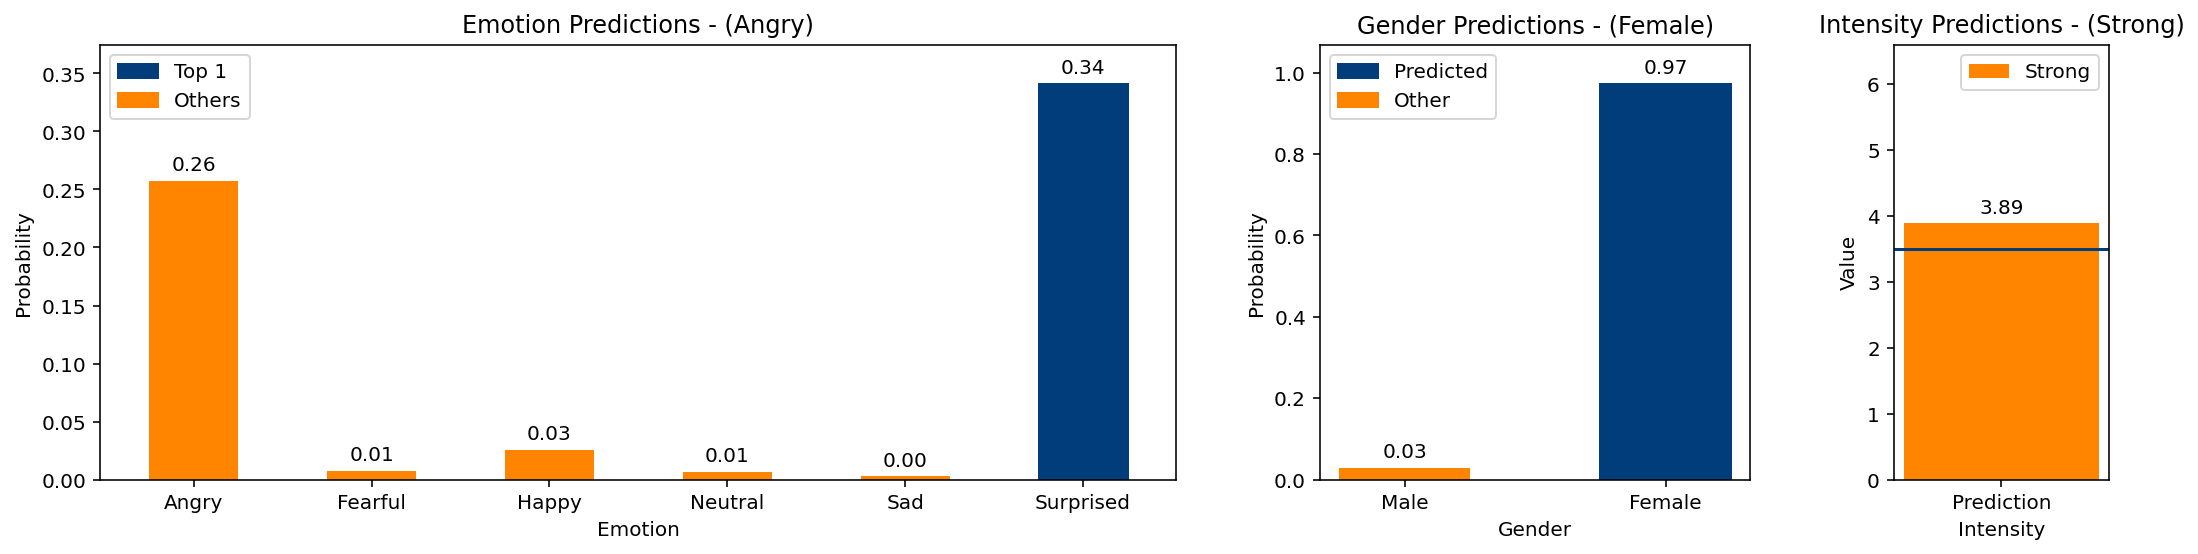

In [39]:
plot_ravdess_prediction(roots, preds, pred_labels, top_k = top_k)

#### Step 4:
Prediction performance on test set images.
> - Each plot displays the predictions made for several spectrograms of a class. 
> - The prediction is the probablity that the spectrogram belongs to that class. 

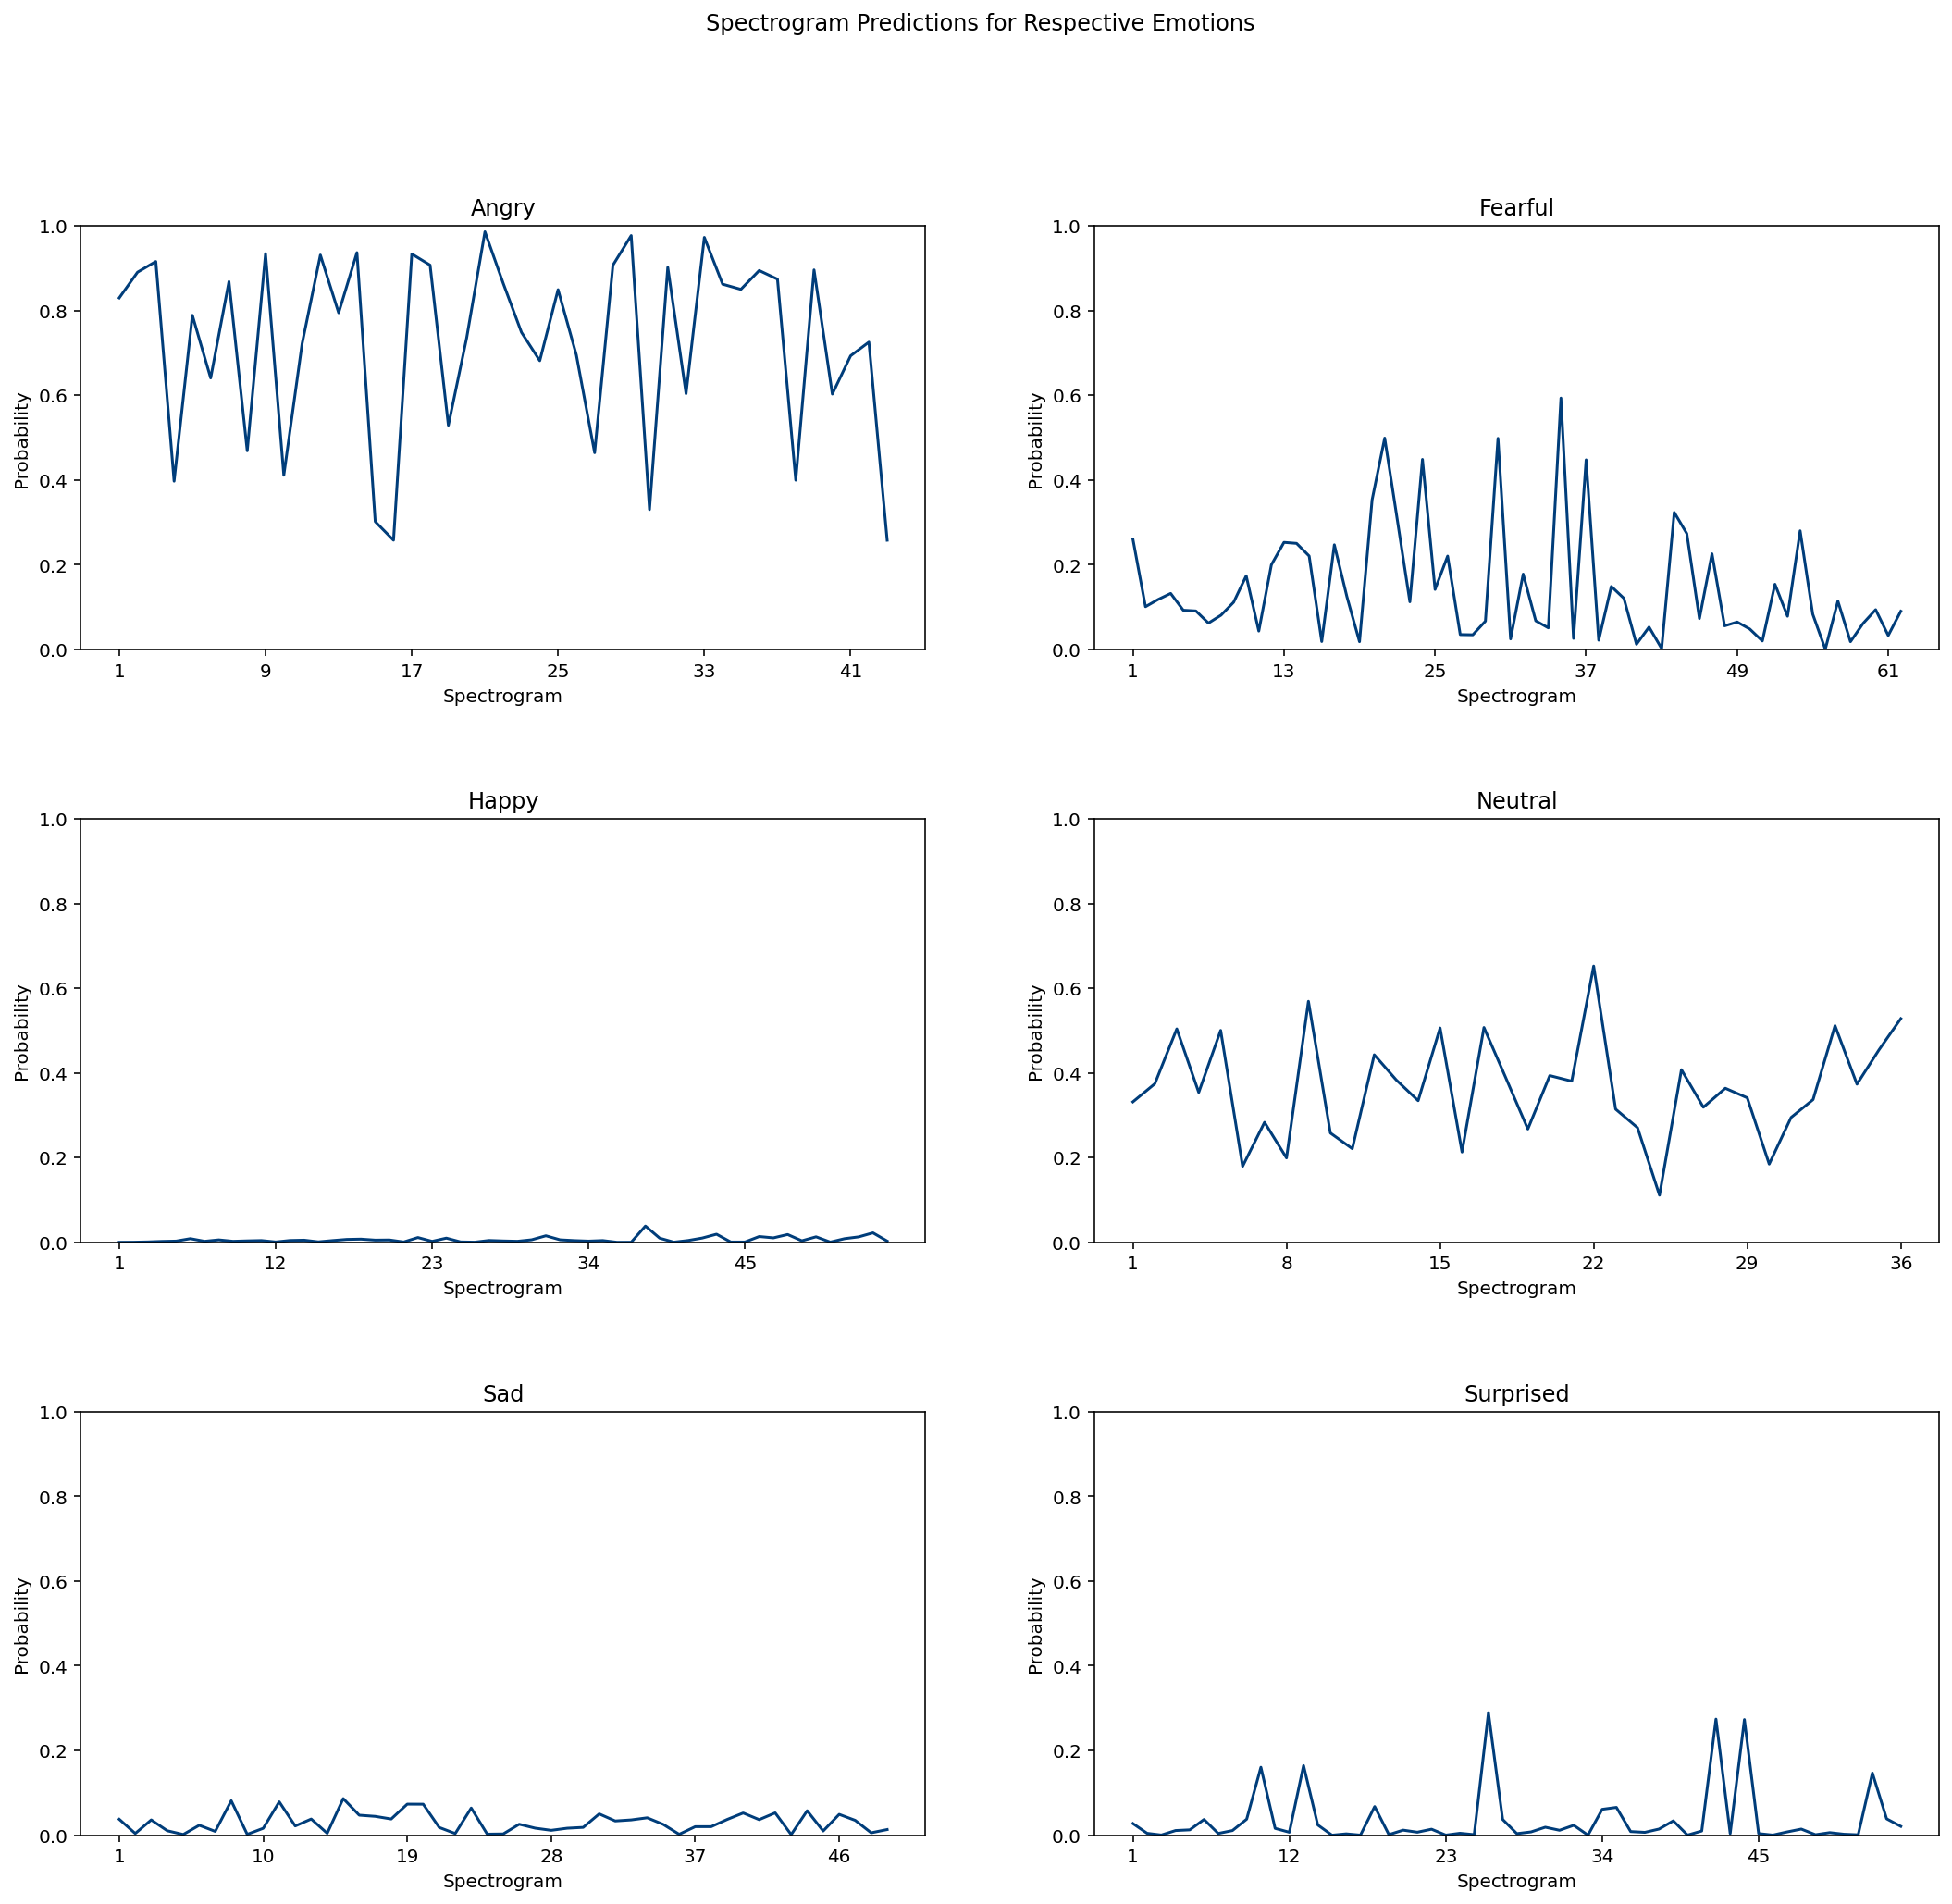

In [40]:
emotion, gender = get_ravdess_classwise(roots, model, plot_params, num_samples = 300)
plot_classwise_pred(emotion, list(rav_class_data.keys())[:-4], 'Emotions', (18, 16))

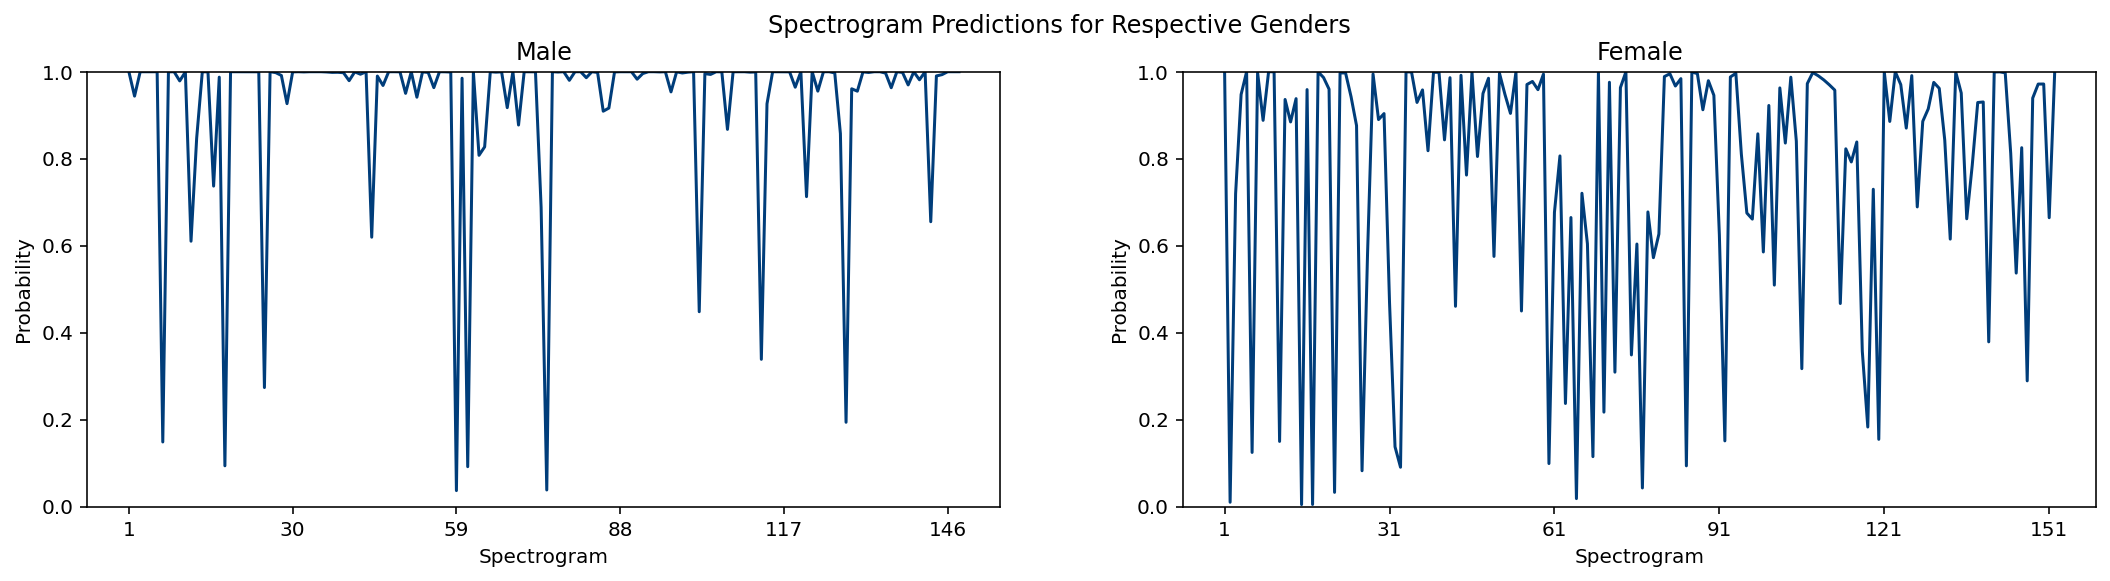

In [41]:
plot_classwise_pred(gender, list(rav_class_data.keys())[-4:-2], 'Genders', (18, 4))

#### Step 5:
Plotting the classification metrics per class.

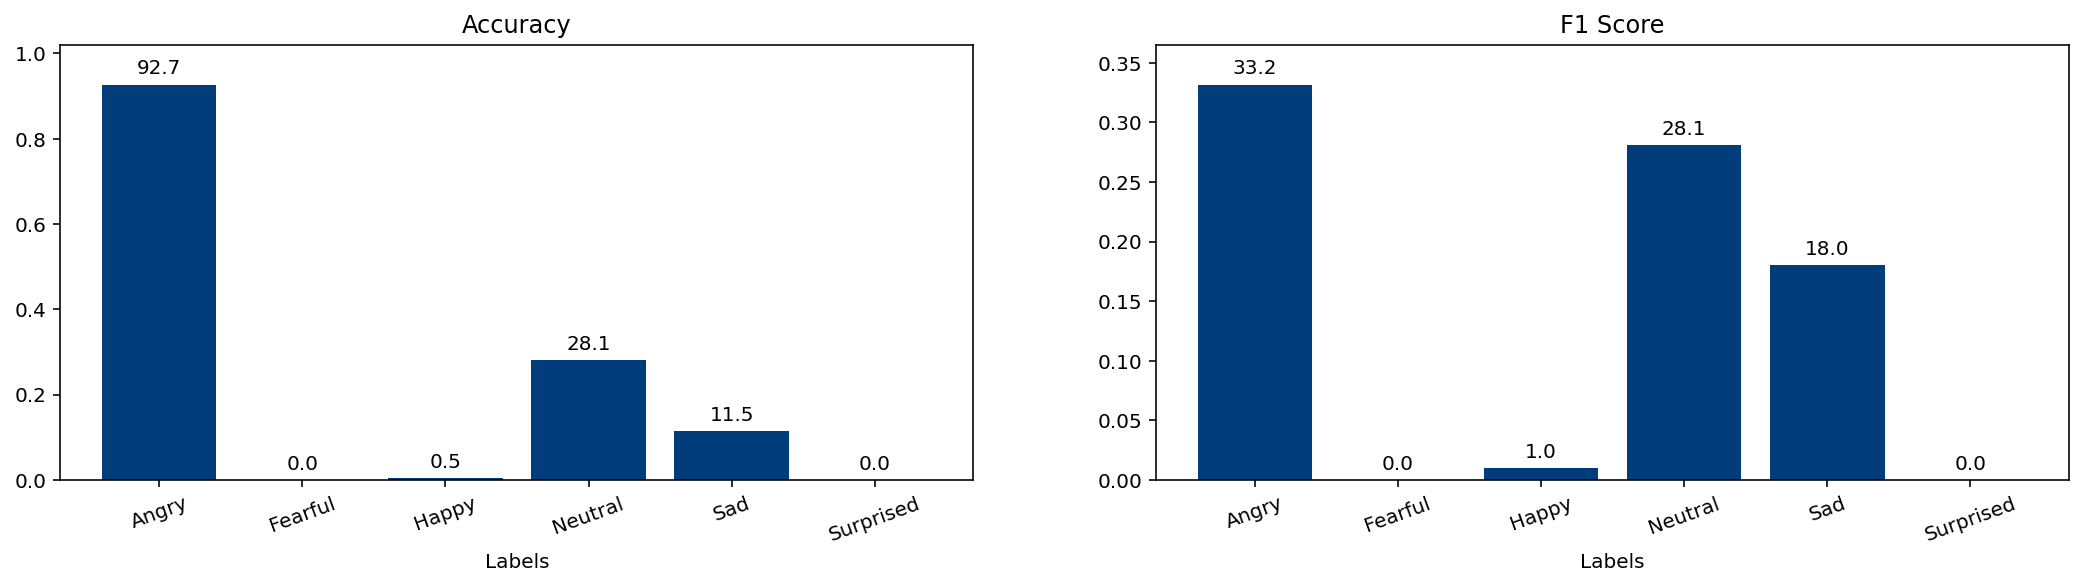

In [42]:
plot_per_class(test_results, tuple(rav_class_data.keys())[:-4], 'Emotion')

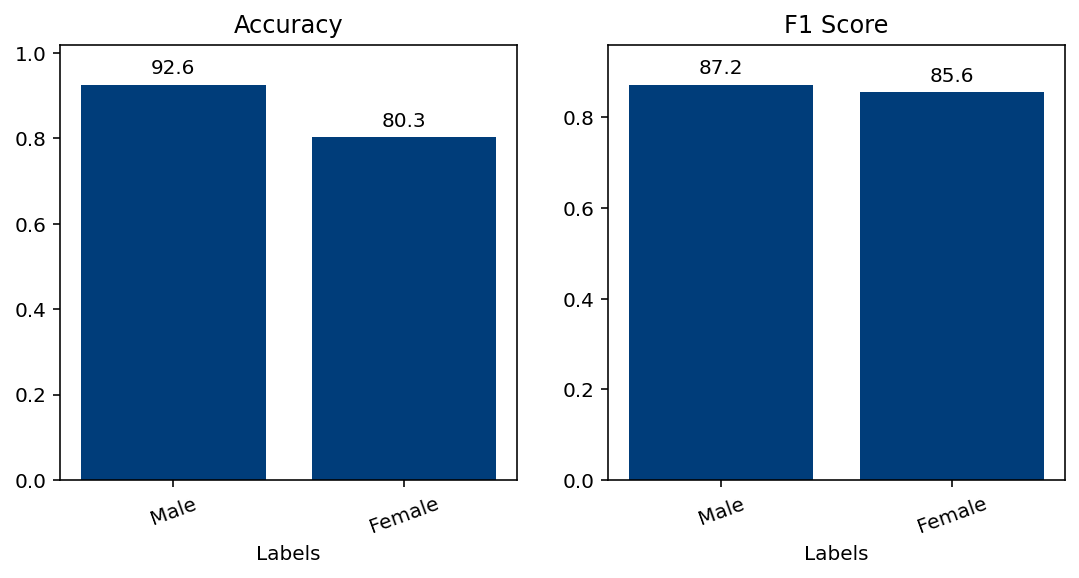

In [43]:
plot_per_class(test_results, tuple(rav_class_data.keys())[-4:-2], 'Gender')

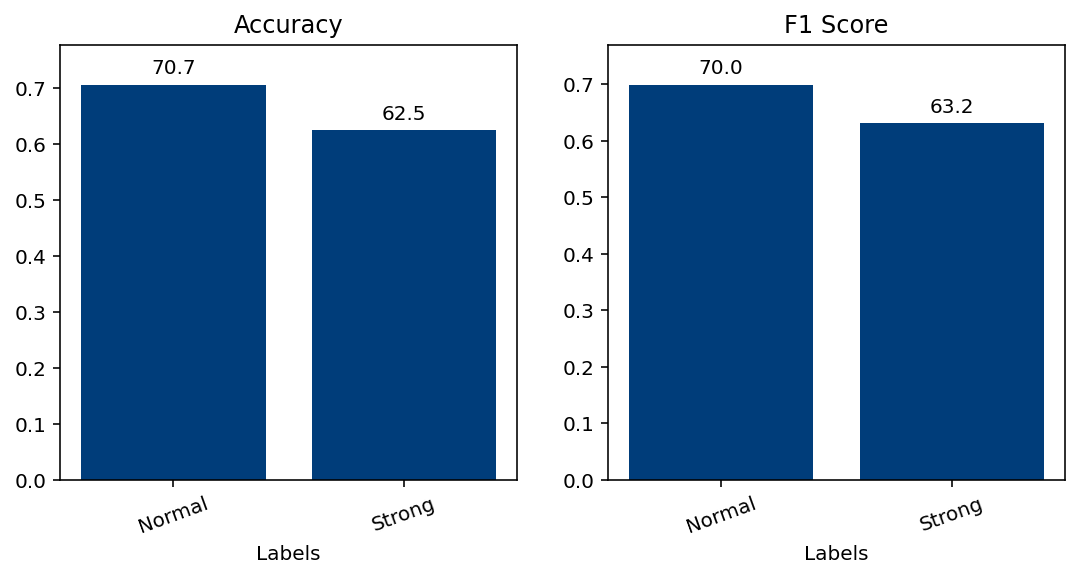

In [44]:
plot_per_class(test_results, tuple(rav_class_data.keys())[-2:], 'Intensity')

#### Step 6:
Plotting the confusion matrix.

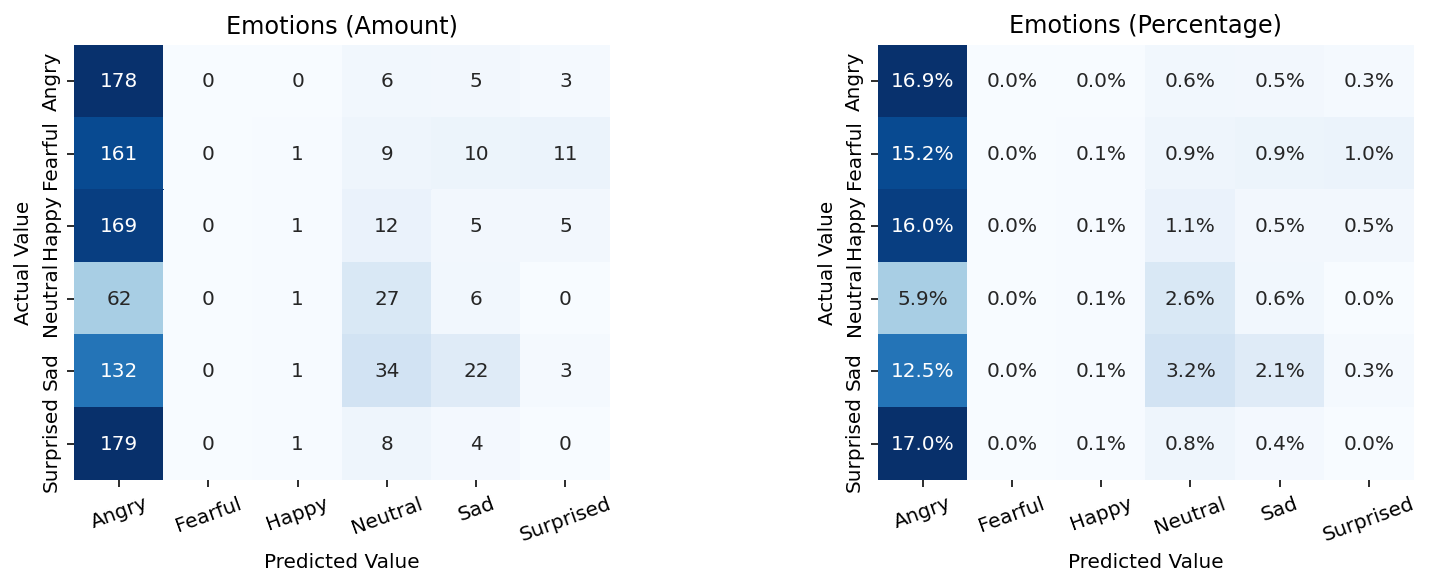

In [45]:
plot_confusion_matrix(test_results['confusion matrix'][0], tuple(rav_class_data.keys())[:-4], 'Emotions', fig_size = (12,4), wspace = 0.5)

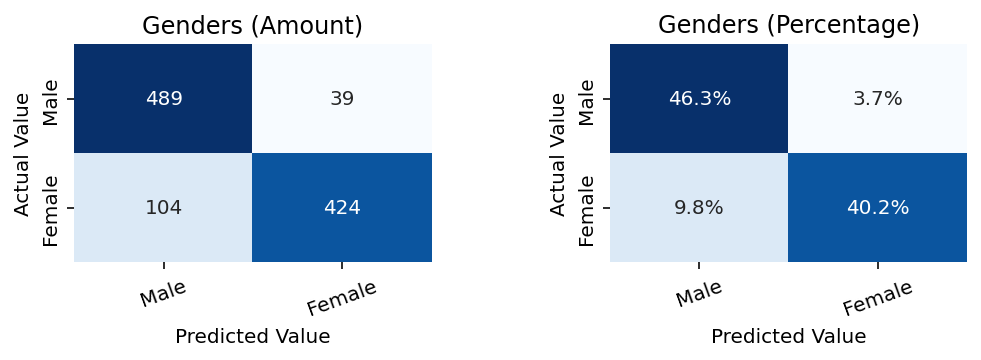

In [46]:
plot_confusion_matrix(test_results['confusion matrix'][1], tuple(rav_class_data.keys())[-4:-2], 'Genders', fig_size = (8,2), wspace = 0.5)

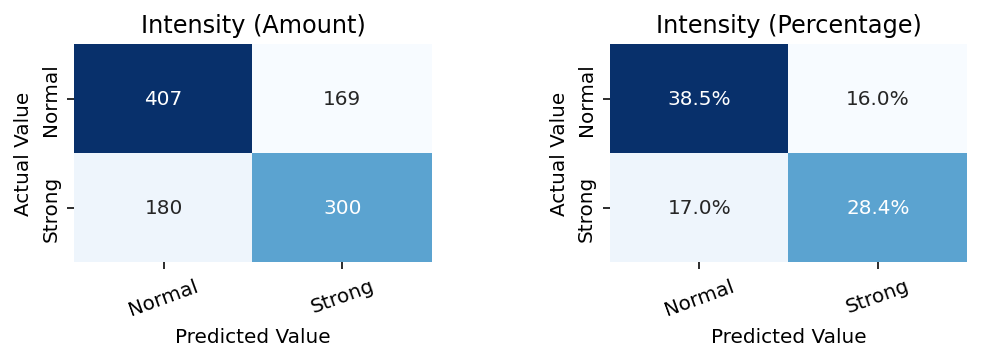

In [47]:
plot_confusion_matrix(test_results['confusion matrix'][2], tuple(rav_class_data.keys())[-2:], 'Intensity', fig_size = (8,2), wspace = 0.5)

<a id='session_three'></a>
## Session III
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- `num_augs` - Number of augmentations of a sample used. In this session, only original samples are used.
- `top_k` - set to **3**. 
- `aug_type` - augmentation to plot.

| Number | Augmentation Type |
| :-: | :-: |
| 1 | Original |

In [62]:
other_params['num augs'] = [1]
aug_type = 1
top_k = 3

metrics_weight = get_classification_metric('weighted', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)
metrics_macro = get_classification_metric('macro', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)
metrics_none = get_classification_metric('none', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)

plot_params = (rav_task_type, aug_type, all_transforms)
torch_params['metrics weight'] = metrics_weight
torch_params['metrics macro'] = metrics_macro
torch_params['metrics none'] = metrics_none

#### Step 1:
Testing the model.

In [63]:
test_ravdess_network(roots, model_params, torch_params, other_params, name = '3')

IntProgress(value=0, description='Making predictions...', layout=Layout(width='500px'), max=2, style=ProgressS…

#### Step 2:
- Loading the model data.
- Displaying the metrics.

In [64]:
test_results = torch.load(f'{rav_meta_root}/Test-3.pt')

In [65]:
columns = ('Task', 'Weighted Accuracy', 'Weighted F1 Score')
display_test_data(test_results['weighted metric'], rav_tasks, columns, 'classification')

columns = ('Task', 'Macro Accuracy', 'Macro F1 Score')
display_test_data(test_results['macro metric'], rav_tasks, columns, 'classification')

Task Weighted Accuracy Weighted F1 Score
1   Emotions             59.00            0.2866
2    Genders             86.65            0.8659
3  Intensity             65.72            0.6579

Task Macro Accuracy Macro F1 Score
1   Emotions          61.02         0.2846
2    Genders          86.65         0.8659
3  Intensity          65.82         0.6564

#### Step 3:
Plotting the predictions of a random image.

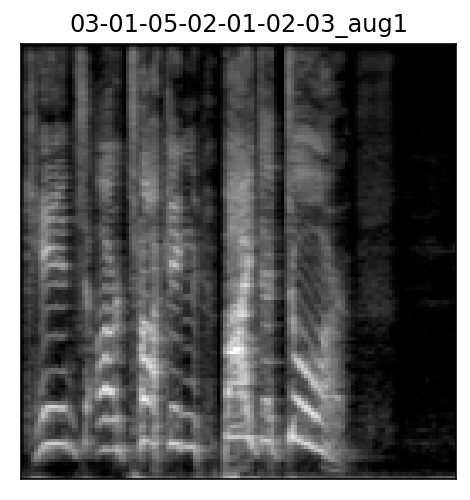

In [66]:
preds, pred_labels, file_name, img = get_single_ravdess(roots, model, 'test', plot_params)
plot_img_pred(file_name, img, color_map, aug_type)

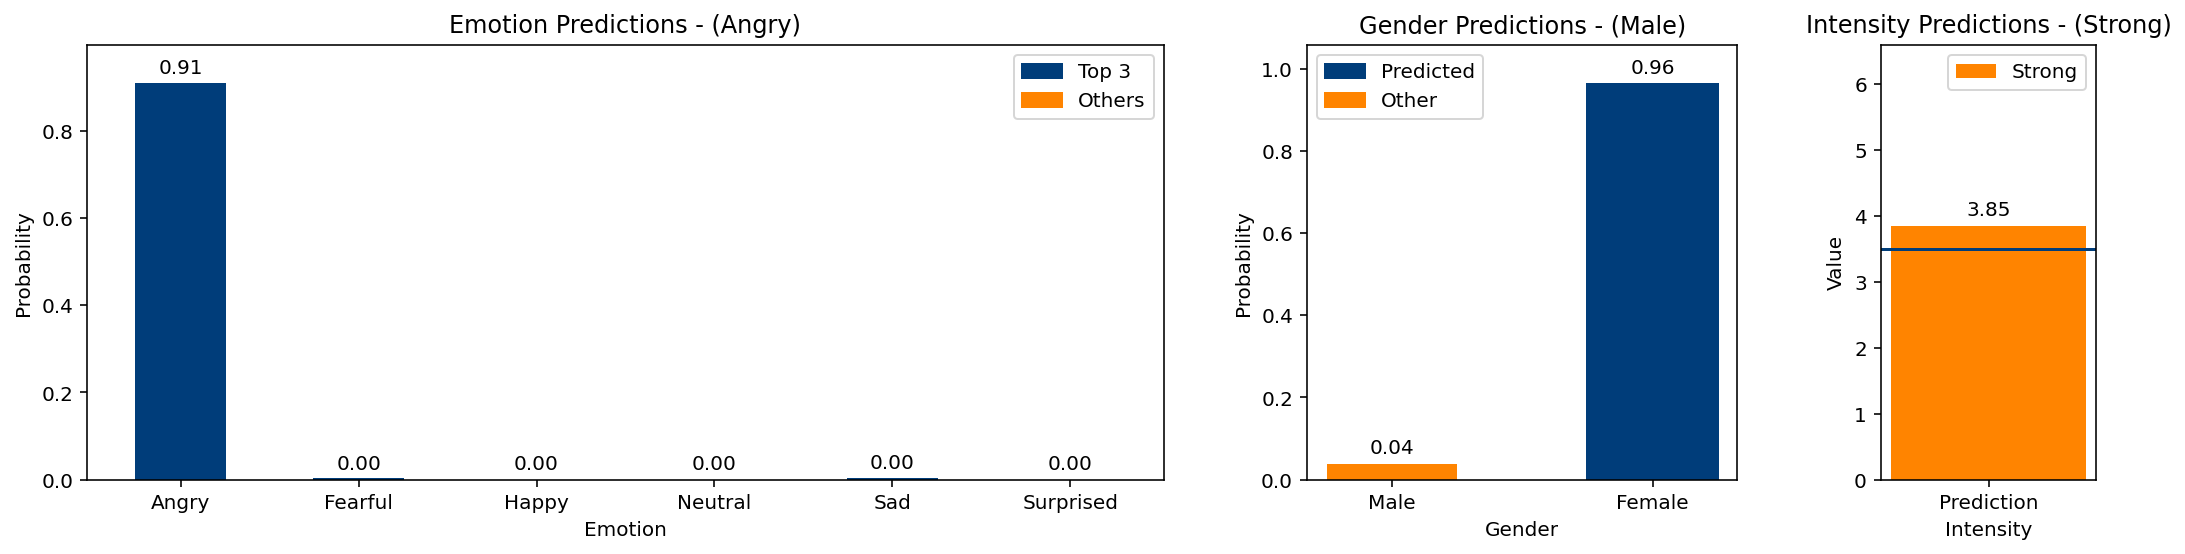

In [67]:
plot_ravdess_prediction(roots, preds, pred_labels, top_k = top_k)

#### Step 4:
Prediction performance on test set images.
> - Each plot displays the predictions made for several spectrograms of a class. 
> - The prediction is the probablity that the spectrogram belongs to that class. 

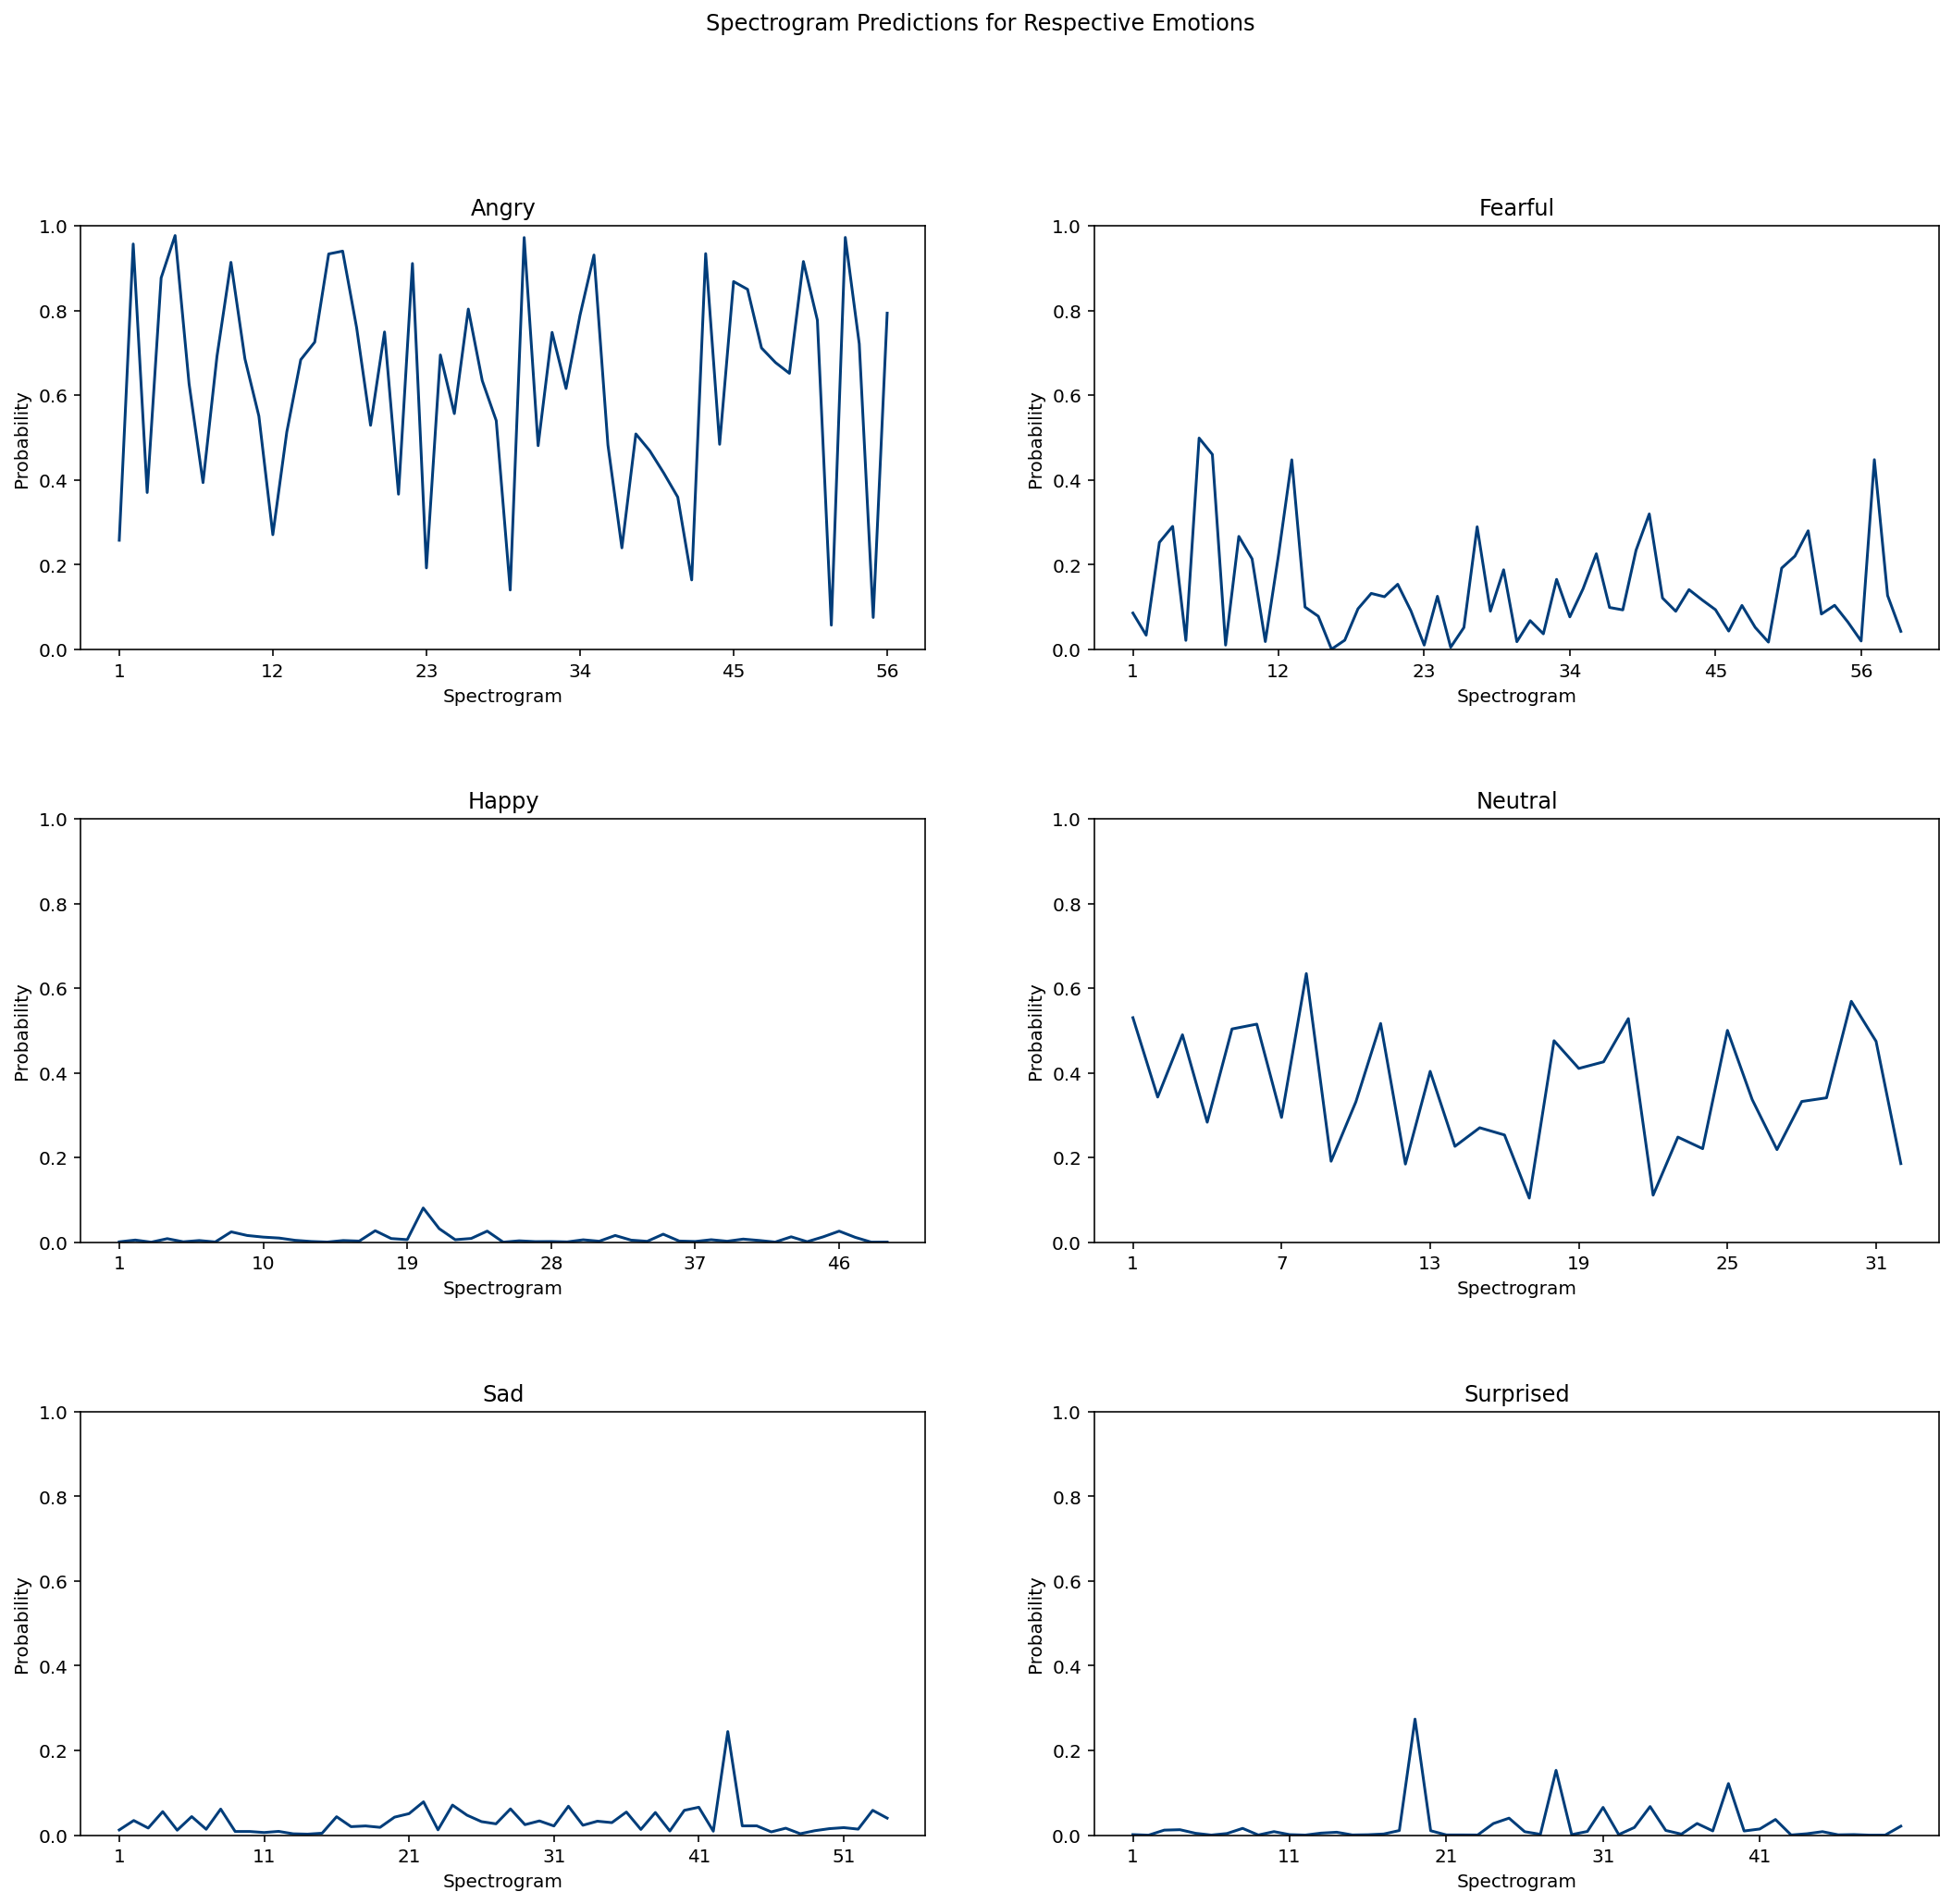

In [68]:
emotion, gender = get_ravdess_classwise(roots, model, plot_params, num_samples = 300)
plot_classwise_pred(emotion, list(rav_class_data.keys())[:-4], 'Emotions', (18, 16))

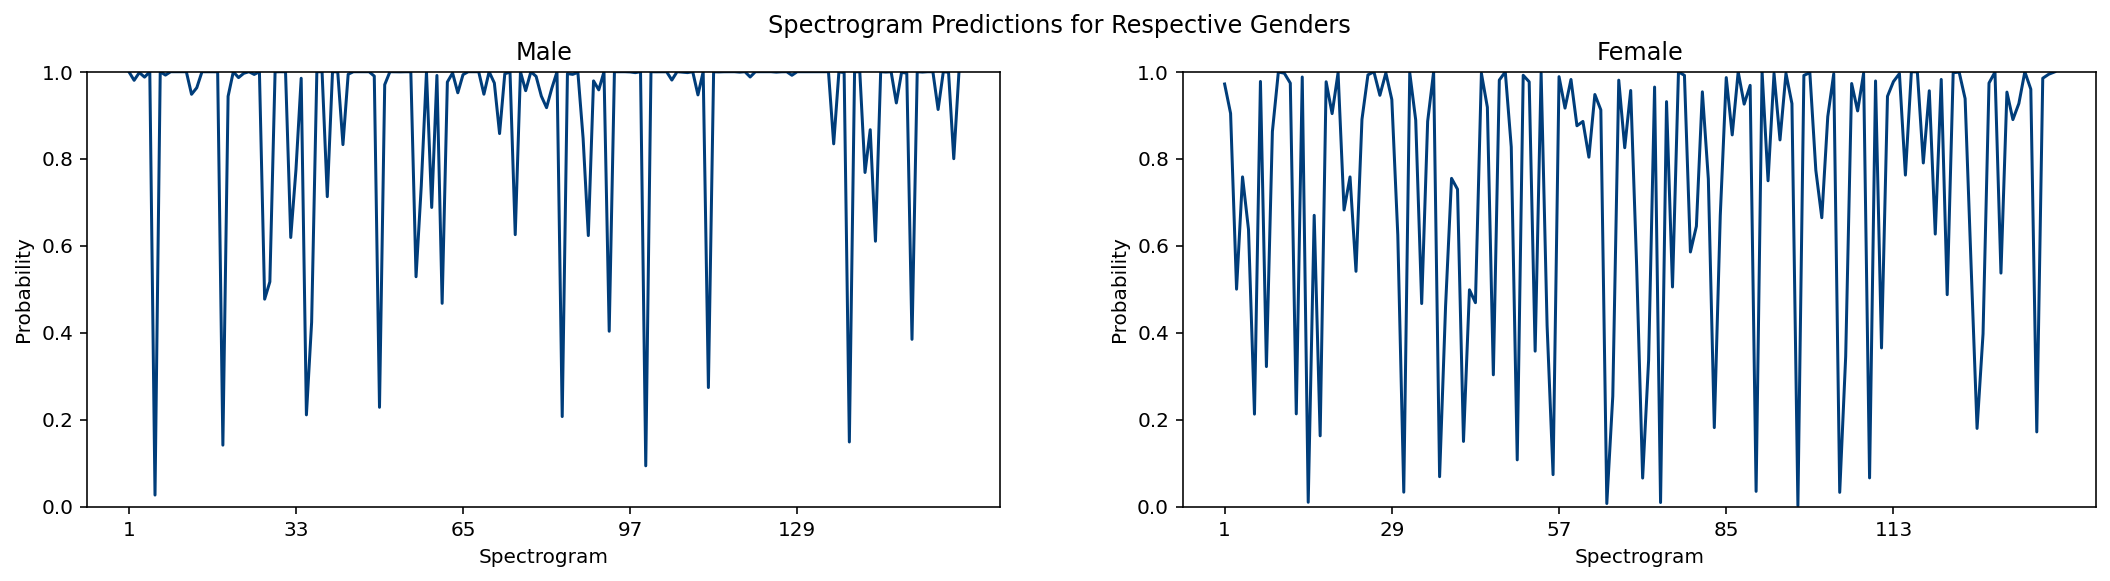

In [69]:
plot_classwise_pred(gender, list(rav_class_data.keys())[-4:-2], 'Genders', (18, 4))

#### Step 5:
Plotting the classification metrics per class.

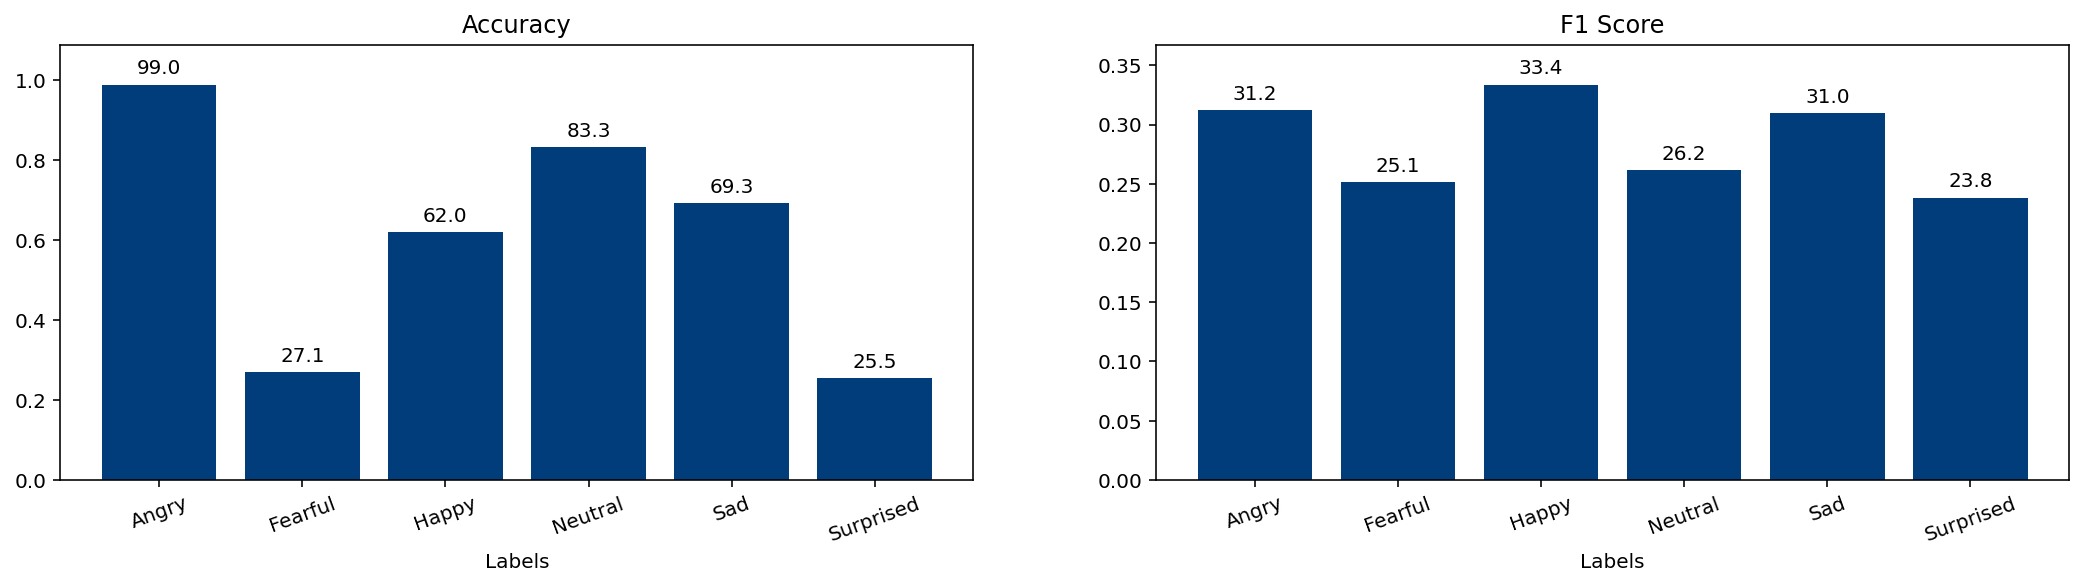

In [70]:
plot_per_class(test_results, tuple(rav_class_data.keys())[:-4], 'Emotion')

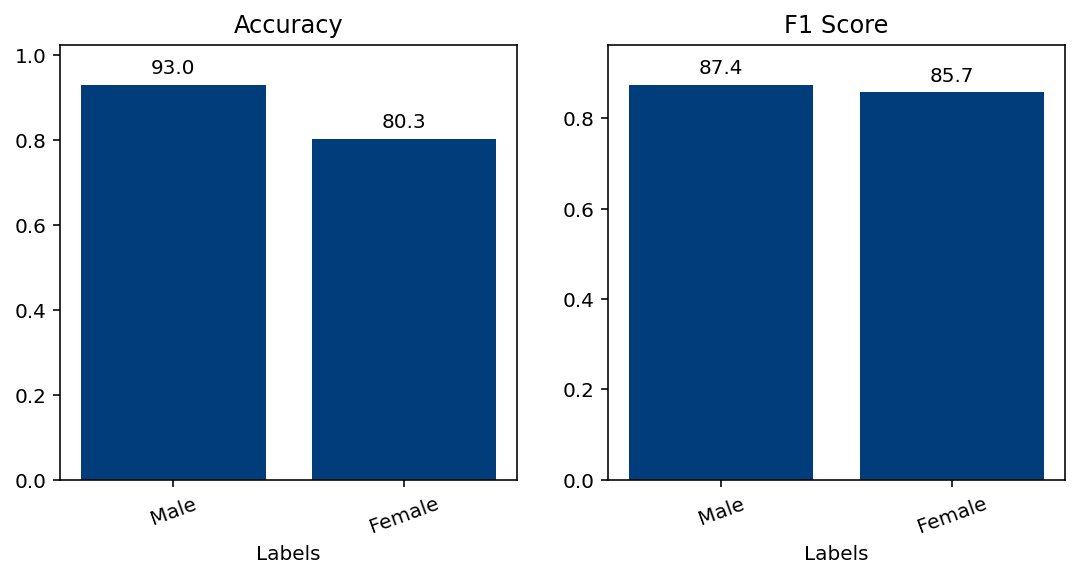

In [71]:
plot_per_class(test_results, tuple(rav_class_data.keys())[-4:-2], 'Gender')

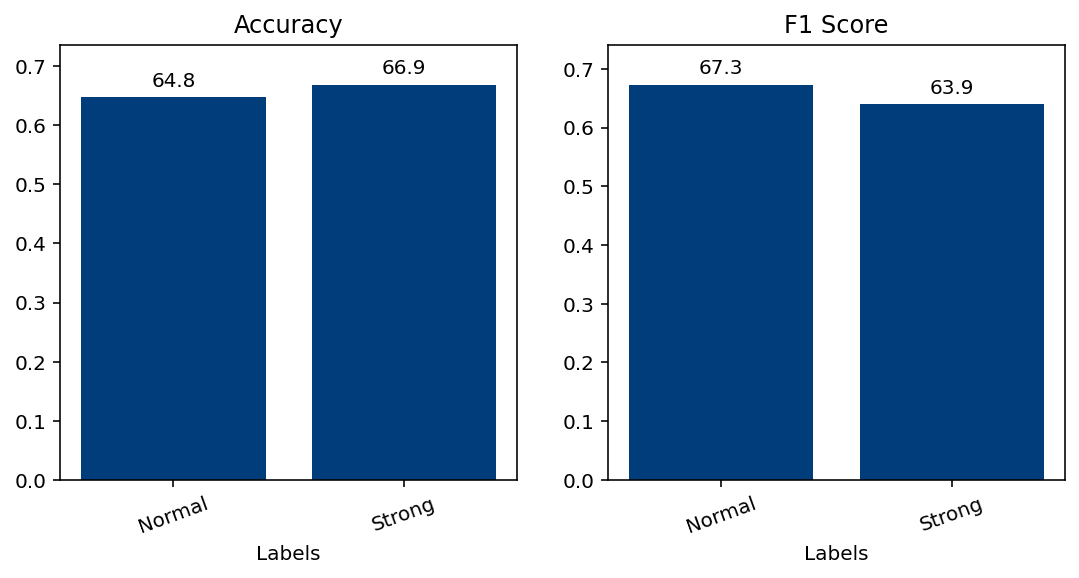

In [72]:
plot_per_class(test_results, tuple(rav_class_data.keys())[-2:], 'Intensity')

#### Step 6:
Plotting the confusion matrix.

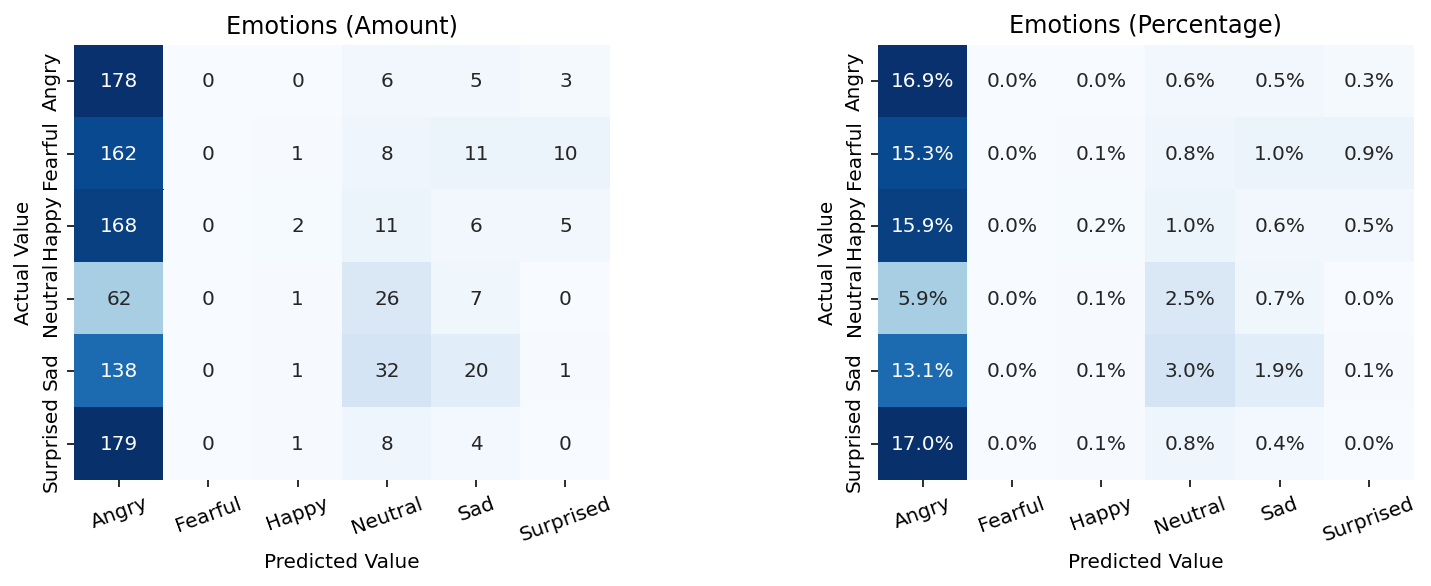

In [73]:
plot_confusion_matrix(test_results['confusion matrix'][0], tuple(rav_class_data.keys())[:-4], 'Emotions', fig_size = (12,4), wspace = 0.5)

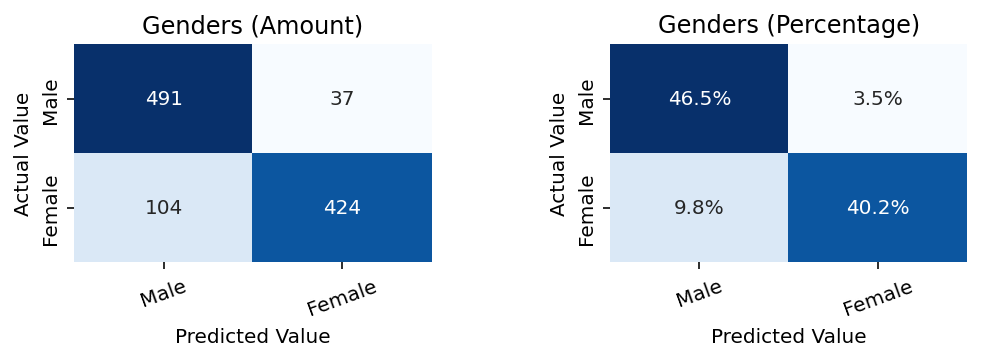

In [74]:
plot_confusion_matrix(test_results['confusion matrix'][1], tuple(rav_class_data.keys())[-4:-2], 'Genders', fig_size = (8,2), wspace = 0.5)

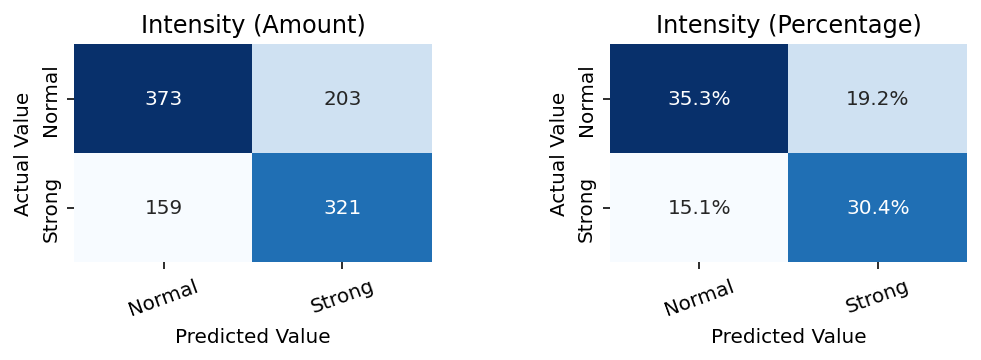

In [75]:
plot_confusion_matrix(test_results['confusion matrix'][2], tuple(rav_class_data.keys())[-2:], 'Intensity', fig_size = (8,2), wspace = 0.5)

<a id='session_four'></a>
## Session IV
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

#### Overview
- `num_augs` - using 3 augmentations.
- `top_k` - set to **3**. 
- `aug_type` - augmentation to plot.

| Number | Augmentation Type |
| :-: | :-: |
| 1 | Original |
| 2 | Noise |
| 3 | Time Stretch |
| 4 | Pitch Shift |

In [76]:
other_params['num augs'] = [1, 2, 3, 4]
aug_type = 1
top_k = 3

metrics_weight = get_classification_metric('weighted', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)
metrics_macro = get_classification_metric('macro', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)
metrics_none = get_classification_metric('none', num_emotion = rav_num_outputs[0], num_gender = rav_num_outputs[1], 
                                          num_intensity = rav_num_outputs[2], top_k = top_k)

plot_params = (rav_task_type, aug_type, all_transforms)
torch_params['metrics weight'] = metrics_weight
torch_params['metrics macro'] = metrics_macro
torch_params['metrics none'] = metrics_none

#### Step 1:
Testing the model.

In [77]:
test_ravdess_network(roots, model_params, torch_params, other_params, name = '4')

IntProgress(value=0, description='Making predictions...', layout=Layout(width='500px'), max=2, style=ProgressS…

#### Step 2:
- Loading the model data.
- Displaying the metrics.

In [78]:
test_results = torch.load(f'{rav_meta_root}/Test-4.pt')

In [79]:
columns = ('Task', 'Weighted Accuracy', 'Weighted F1 Score')
display_test_data(test_results['weighted metric'], rav_tasks, columns, 'classification')

columns = ('Task', 'Macro Accuracy', 'Macro F1 Score')
display_test_data(test_results['macro metric'], rav_tasks, columns, 'classification')

Task Weighted Accuracy Weighted F1 Score
1   Emotions             59.94            0.2919
2    Genders             86.46            0.8641
3  Intensity             66.95            0.6692

Task Macro Accuracy Macro F1 Score
1   Emotions          62.15         0.2892
2    Genders          86.46         0.8641
3  Intensity          66.58         0.6661

#### Step 3:
Plotting the predictions of a random image.

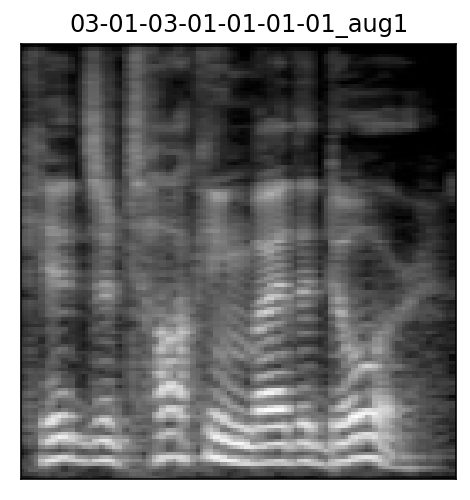

In [80]:
preds, pred_labels, file_name, img = get_single_ravdess(roots, model, 'test', plot_params)
plot_img_pred(file_name, img, color_map, aug_type)

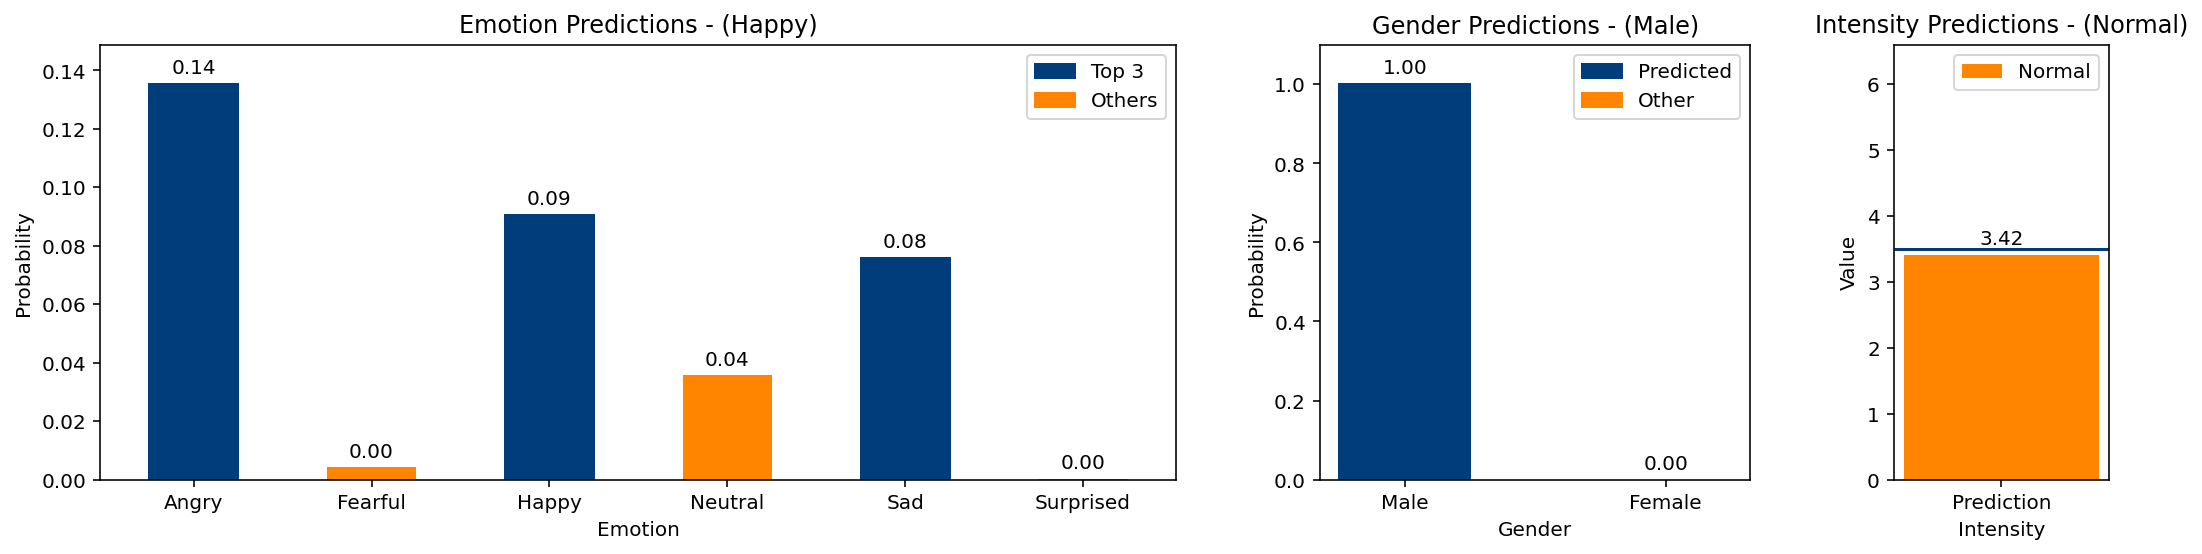

In [81]:
plot_ravdess_prediction(roots, preds, pred_labels, top_k = top_k)

#### Step 4:
Prediction performance on test set images.
> - Each plot displays the predictions made for several spectrograms of a class. 
> - The prediction is the probablity that the spectrogram belongs to that class. 

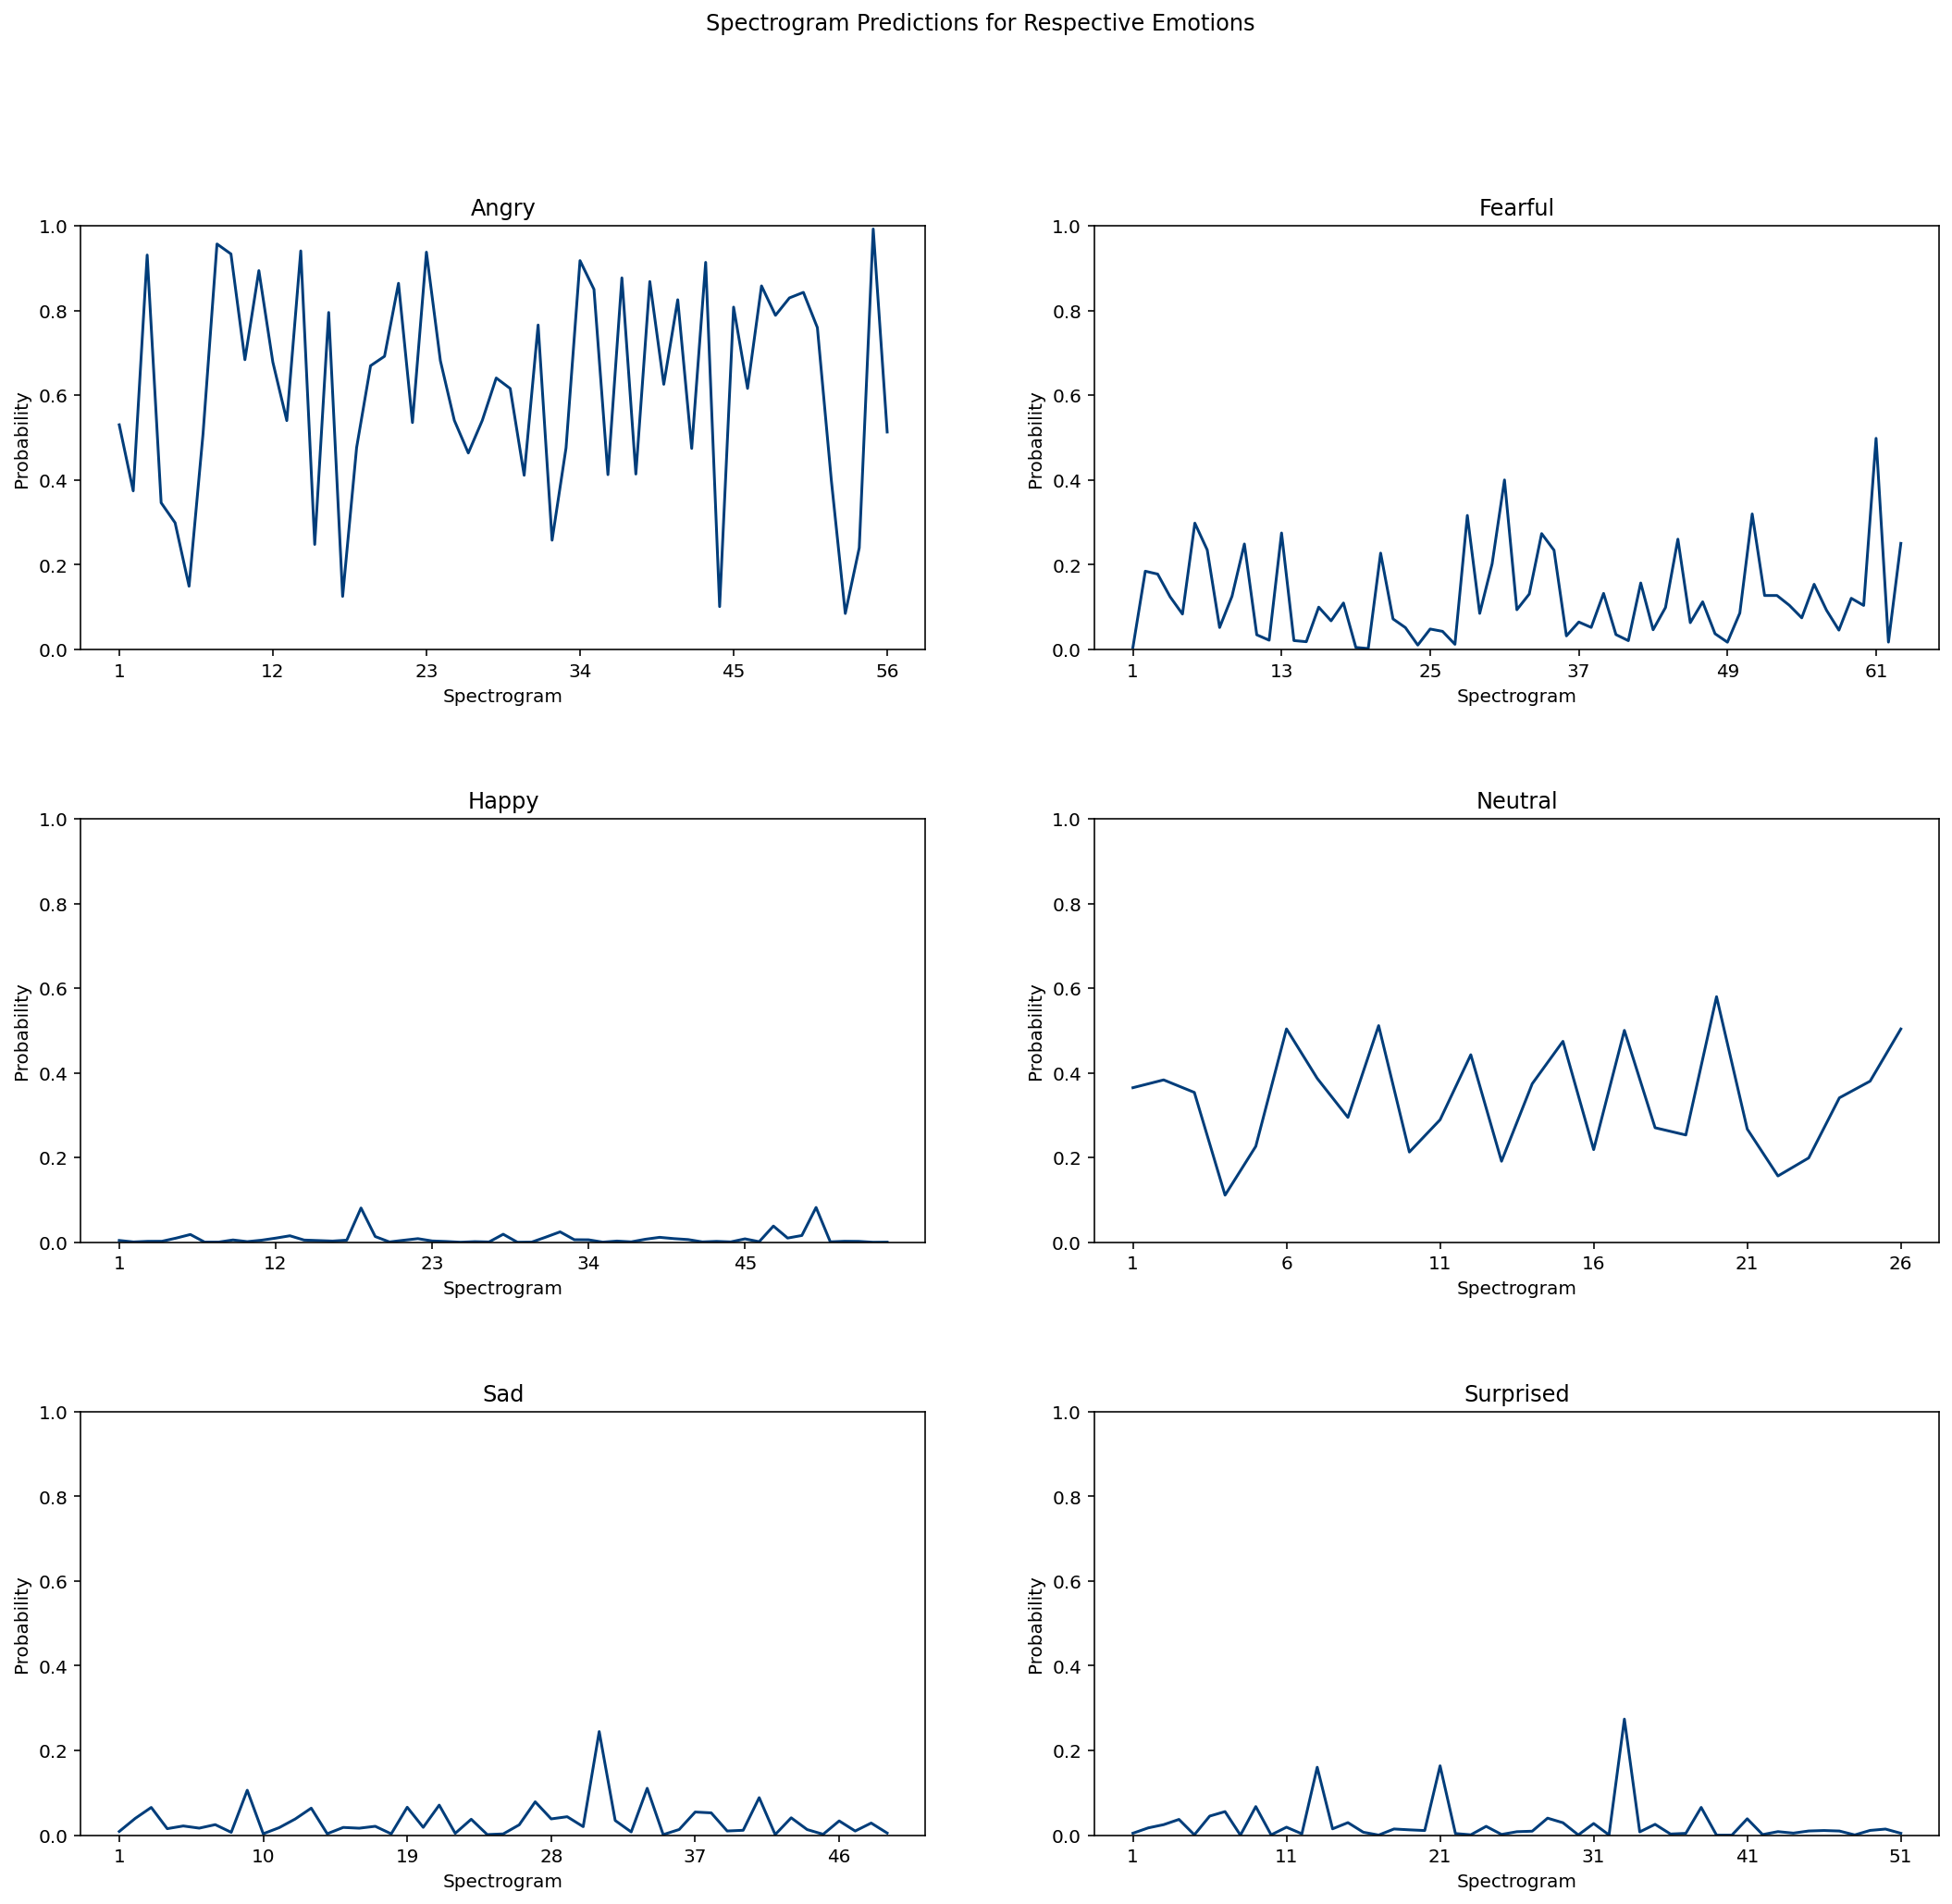

In [82]:
emotion, gender = get_ravdess_classwise(roots, model, plot_params, num_samples = 300)
plot_classwise_pred(emotion, list(rav_class_data.keys())[:-4], 'Emotions', (18, 16))

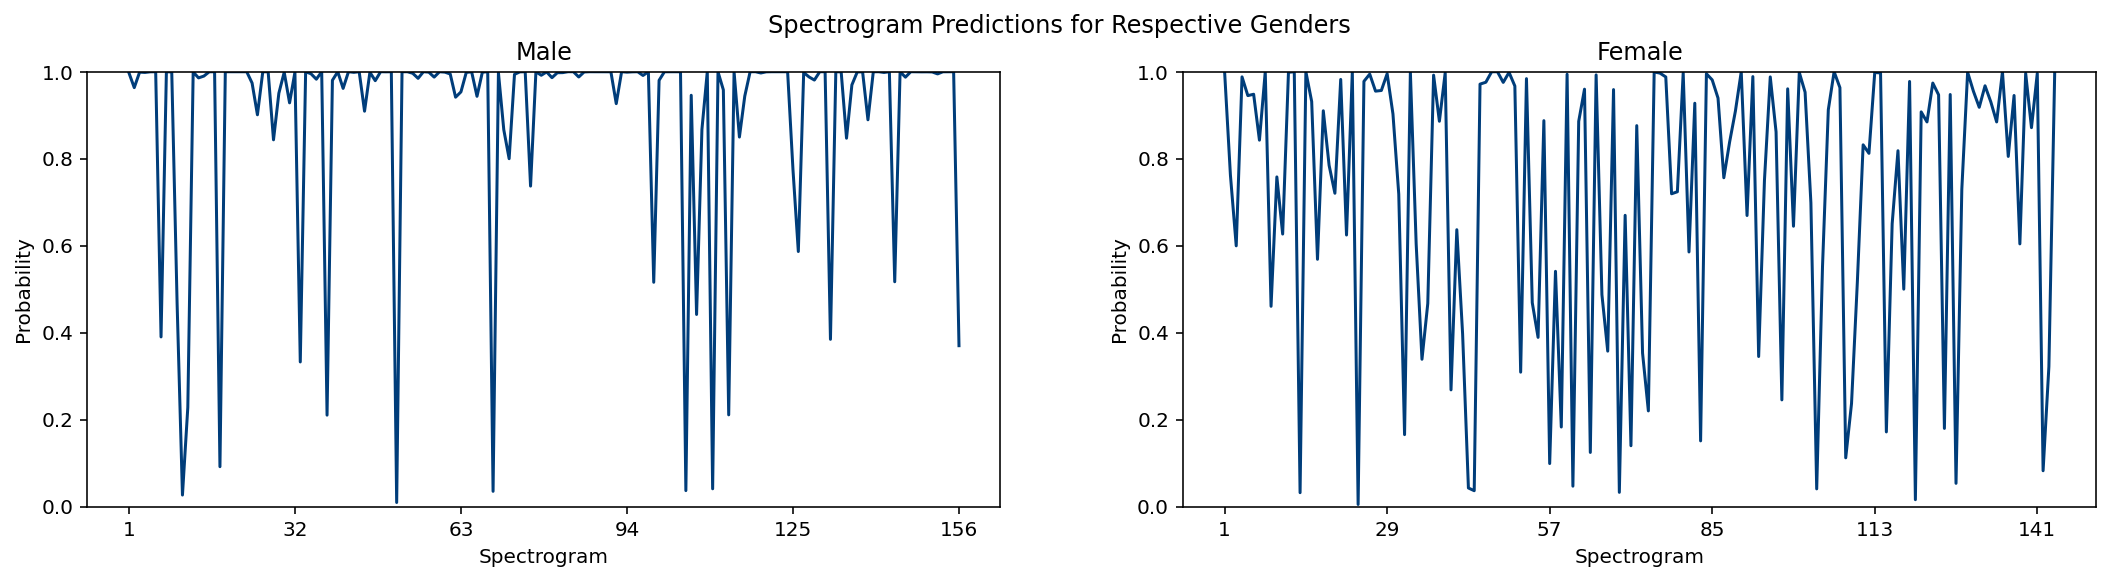

In [83]:
plot_classwise_pred(gender, list(rav_class_data.keys())[-4:-2], 'Genders', (18, 4))

#### Step 5:
Plotting the classification metrics per class.

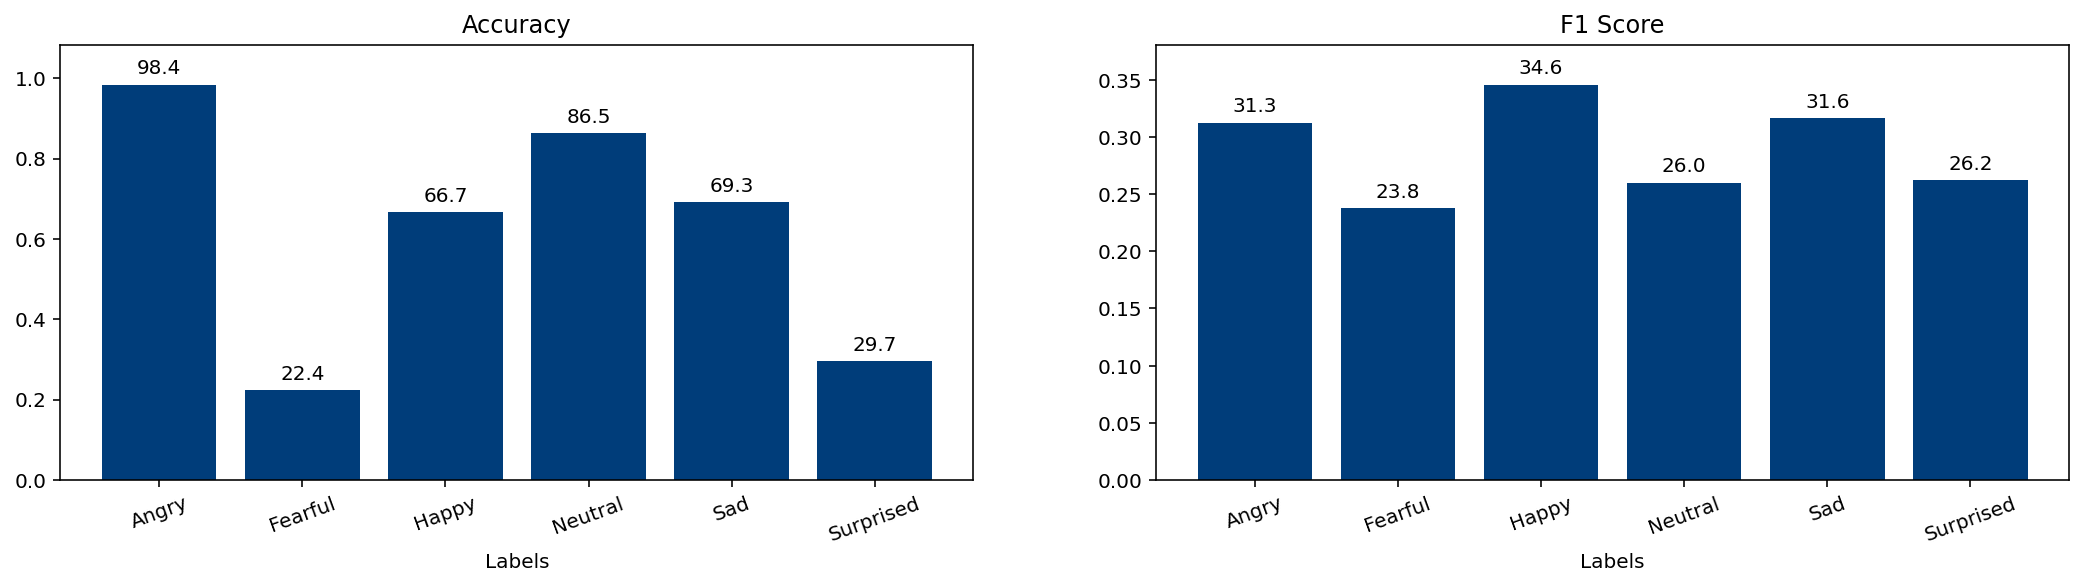

In [84]:
plot_per_class(test_results, tuple(rav_class_data.keys())[:-4], 'Emotion')

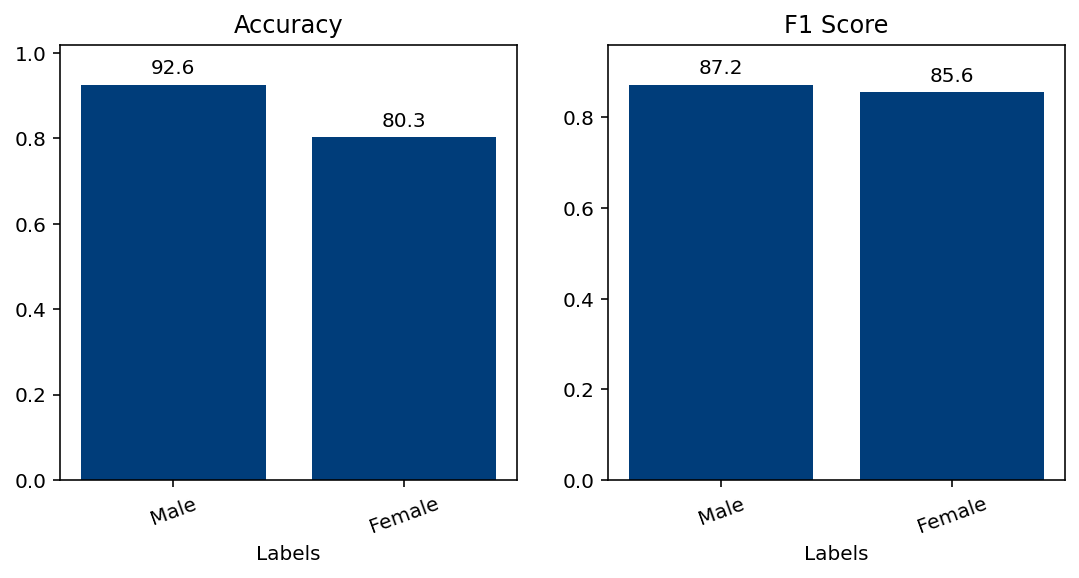

In [85]:
plot_per_class(test_results, tuple(rav_class_data.keys())[-4:-2], 'Gender')

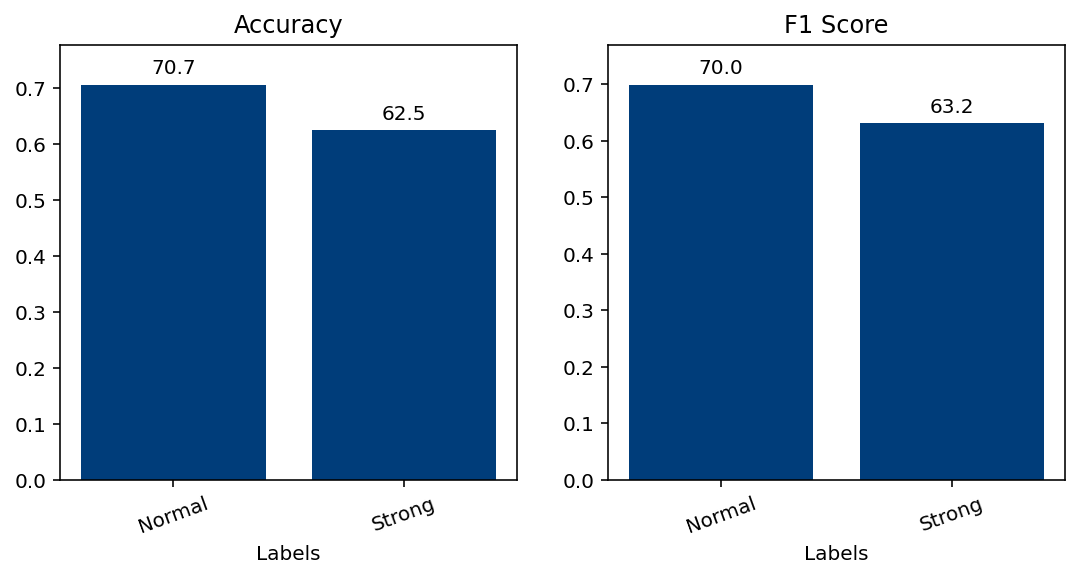

In [86]:
plot_per_class(test_results, tuple(rav_class_data.keys())[-2:], 'Intensity')

#### Step 6:
Plotting the confusion matrix.

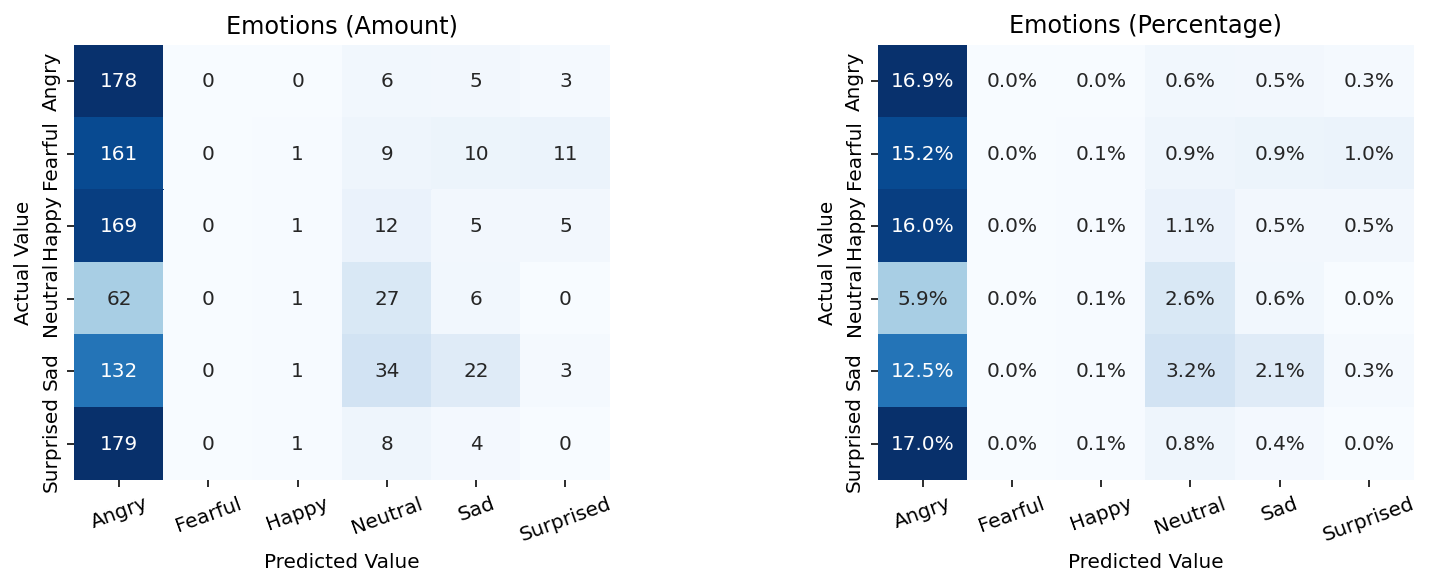

In [87]:
plot_confusion_matrix(test_results['confusion matrix'][0], tuple(rav_class_data.keys())[:-4], 'Emotions', fig_size = (12,4), wspace = 0.5)

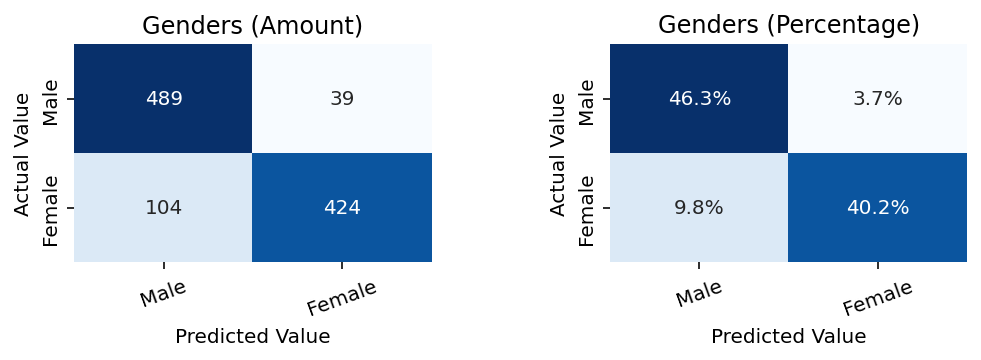

In [88]:
plot_confusion_matrix(test_results['confusion matrix'][1], tuple(rav_class_data.keys())[-4:-2], 'Genders', fig_size = (8,2), wspace = 0.5)

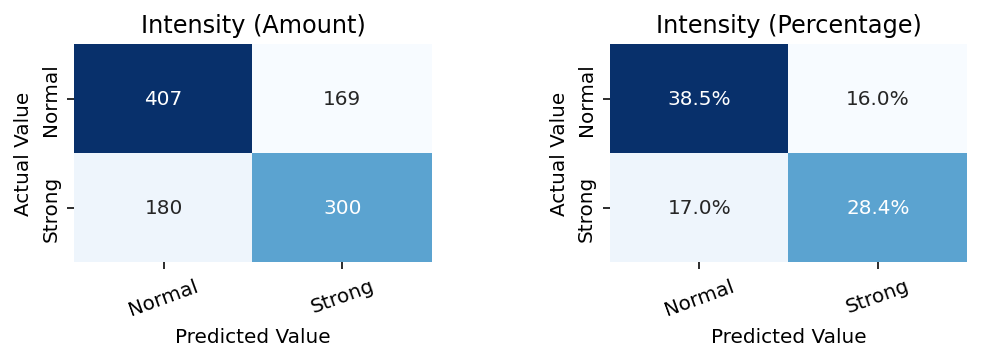

In [89]:
plot_confusion_matrix(test_results['confusion matrix'][2], tuple(rav_class_data.keys())[-2:], 'Intensity', fig_size = (8,2), wspace = 0.5)

<a id='save'></a>
## Save File
<hr style="height: 0.5px; background-color: gray; opacity: 0.3">

Saving the test results.

In [90]:
!zip -r 'RAVDESS Meta.zip' 'RAVDESS Meta'
!cp 'RAVDESS Meta.zip' '/content/gdrive/My Drive/Speech Emotion Recognition Project/RAVDESS Meta.zip'

updating: RAVDESS Meta/ (stored 0%)
updating: RAVDESS Meta/Split.json (deflated 90%)
updating: RAVDESS Meta/Label.json (deflated 92%)
updating: RAVDESS Meta/Detail.json (deflated 90%)
updating: RAVDESS Meta/Class.json (deflated 27%)
  adding: RAVDESS Meta/Test-1.pt (deflated 66%)
  adding: RAVDESS Meta/Test-4.pt (deflated 66%)
  adding: RAVDESS Meta/Test-3.pt (deflated 66%)
  adding: RAVDESS Meta/Test-2.pt (deflated 66%)
